# **CSC17103 - Colab 3 - Phân hoạch và phát hiện cộng đồng trên đồ thị**

Đây là Bài tập 03 trong môn học Khai thác Dữ liệu Đồ thị (Graph Mining) - CSC1703 tại Khoa Công nghệ Thông tin, Trường Đại học Khoa học Tự nhiên, Đại học Quốc gia TP.HCM

(Cập nhật lần cuối: 21/07/2024)

Họ tên: Đoàn Ngọc Mai

MSSV: 21127104

## **Cách thực hiện và nộp bài tập**

&#9889; Chú ý, bạn nên thực hiện theo sự hướng dẫn dưới đây. Nếu có bất kỳ điều gì không rõ, bạn cần liên hệ ngay trợ giảng/ giáo viên thực hành để được hỗ trợ kịp thời.

**Cách làm bài**

Bạn sẽ làm trực tiếp trên file notebook này. Đầu tiên, bạn điền họ tên và MSSV vào phần đầu file ở bên trên. Trong file, bạn làm bài ở những chỗ có ghi là:
```python
# YOUR CODE HERE
raise NotImplementedError()
```
hoặc đối với những phần code không bắt buộc thì là:
```python
# YOUR CODE HERE (OPTION)
```
hoặc đối với markdown cell thì là:
```markdown
YOUR ANSWER HERE
```

**Cách nộp bài**

Trước khi nộp bài, bạn chọn `Kernel` - `Restart Kernel & Run All Cells` đối với trường hợp sử dụng môi trường local hoặc `Runtime` - `Restart session and run all` đối với môi trường Google Colab, để đảm bảo mọi chuyện diễn ra đúng như mong đợi.

Sau đó, bạn tạo thư mục nộp bài theo cấu trúc sau:
- Thư mục `MSSV` (ví dụ, nếu bạn có MSSV là 1234567 thì bạn đặt tên thư mục là `1234567`)
    - File `CSC17103_Colab_06.ipynb` (không cần nộp các file khác)

Cuối cùng, bạn nén thư mục `MSSV` này lại với định dạng nén là .zip (chứ không được là .rar hay các định dạng khác) và nộp ở link trên moodle. \
<font color=red>Bạn lưu ý tuân thủ chính xác qui định nộp bài này.</font>

## Setup và Import các thứ

In [1]:
# Upgrade packages
# !pip install --upgrade scipy networkx

In [2]:
# Import
import numpy as np # For numerical computation
import networkx as nx # For network/ graph manipulation
import matplotlib.pyplot as plt # For visualization
import scipy.stats as st
from scipy.stats import ks_2samp
from zlib import adler32

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import pandas as pd
import seaborn as sns

from IPython.display import clear_output

from collections import Counter
import random

plt.style.use("fast")

from typing import List, Tuple, Dict

%matplotlib inline

In [3]:
# Make sure something
assert nx.__version__ > '2.5'

## Thu thập dữ liệu

Trong bài tập này, chúng ta xem xét dữ liệu đồ thị Les Miserables.

In [4]:
G = nx.Graph()
G.add_edges_from(nx.les_miserables_graph().edges)
pos = nx.kamada_kawai_layout(G)

Trực quan hóa

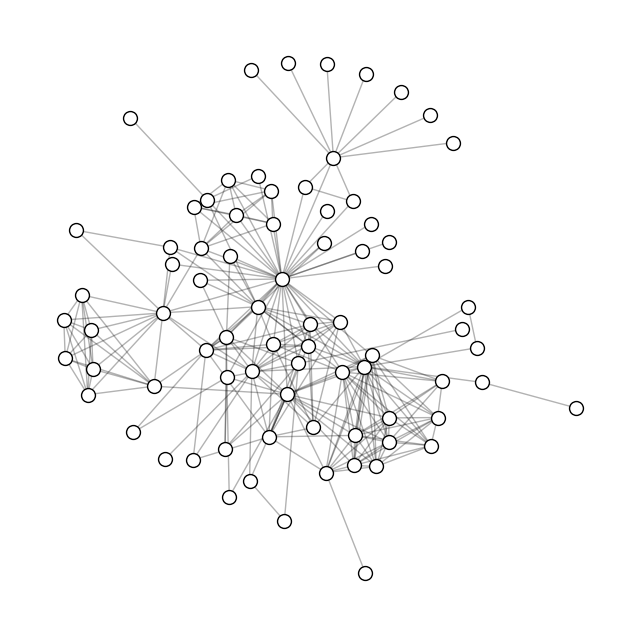

In [5]:
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color='white', edgecolors='black', node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.show()

## Khám phá dữ liệu

Một số thông tin thống kê cơ bản.

In [6]:
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))

Number of nodes 77
Number of edges 254
Average degree 6.597402597402597


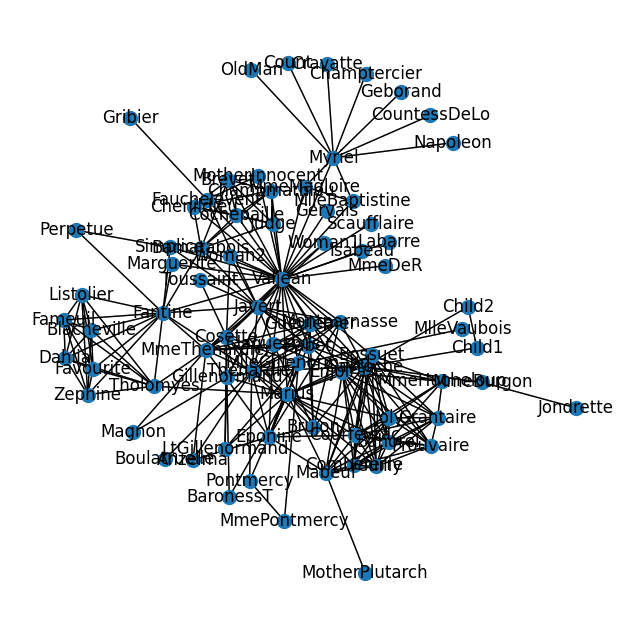

In [7]:
plt.figure(figsize=(8, 8))
nx.draw_networkx(G, pos, with_labels=True, node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.show()

## Task 1. Phân rã $k$-core

Trong phần này, chúng ta sẽ áp dụng phân rã $k$-core ($k$-core decomposition) cho mạng lưới này. Bạn sử dụng `nx.core_number` và tô màu mọi đỉnh bằng $k$-shell của nó.

Để hoàn này task này, bạn viết hàm `kcoreDecomposition` mà nhận đầu vào là một đồ thị `G` và trả về một mảng np.array với $k$ phần tử $k$-shell của đỉnh. Ví dụ, nếu ta có các đỉnh 1, 2, 3, 4 và đỉnh 1 nằm trong 1-shell, các đỉnh 2, 3, 4 thì nằm trong 2-shell thì đầu ra sẽ là [1, 2, 2, 2].


In [8]:
def kcoreDecomposition(G: nx.Graph) -> np.ndarray:
    # YOUR CODE HERE
    core_num = nx.core_number(G)

    k_shell_array = np.zeros(len(G.nodes),dtype=int)

    for node in G.nodes:
        k_shell_array[list(G.nodes).index(node)] = core_num[node]
    
    return k_shell_array

In [9]:
# Test
labels = kcoreDecomposition(G)
assert isinstance(labels, np.ndarray), "Output should be a numpy array"
assert labels.shape == (77,), "Output should be an array of shape (77,)"
assert labels.min() == 1, "Minimum core number should be 1"
assert labels.max() == 9, "Maximum core number should be 9"
assert labels[10] == 8
assert labels[65] == 9

expected_values = {
    10: 8,
    20: 8,
    30: 6,
    40: 8,
    50: 7,
    60: 2,
    65: 9
}
for index, value in expected_values.items():
    assert labels[index] == value, f"Core number at index {index} should be {value}"

unique, counts = np.unique(labels, return_counts=True)
counts_dict = dict(zip(unique, counts))

expected_counts = {
    1: 18,
    2: 11,
    3: 7,
    4: 3,
    6: 7,
    7: 11,
    8: 8,
    9: 12
}

for core_num, count in expected_counts.items():
    assert counts_dict[core_num] == count, f"Core number {core_num} should appear {count} times"

Trực quan hóa

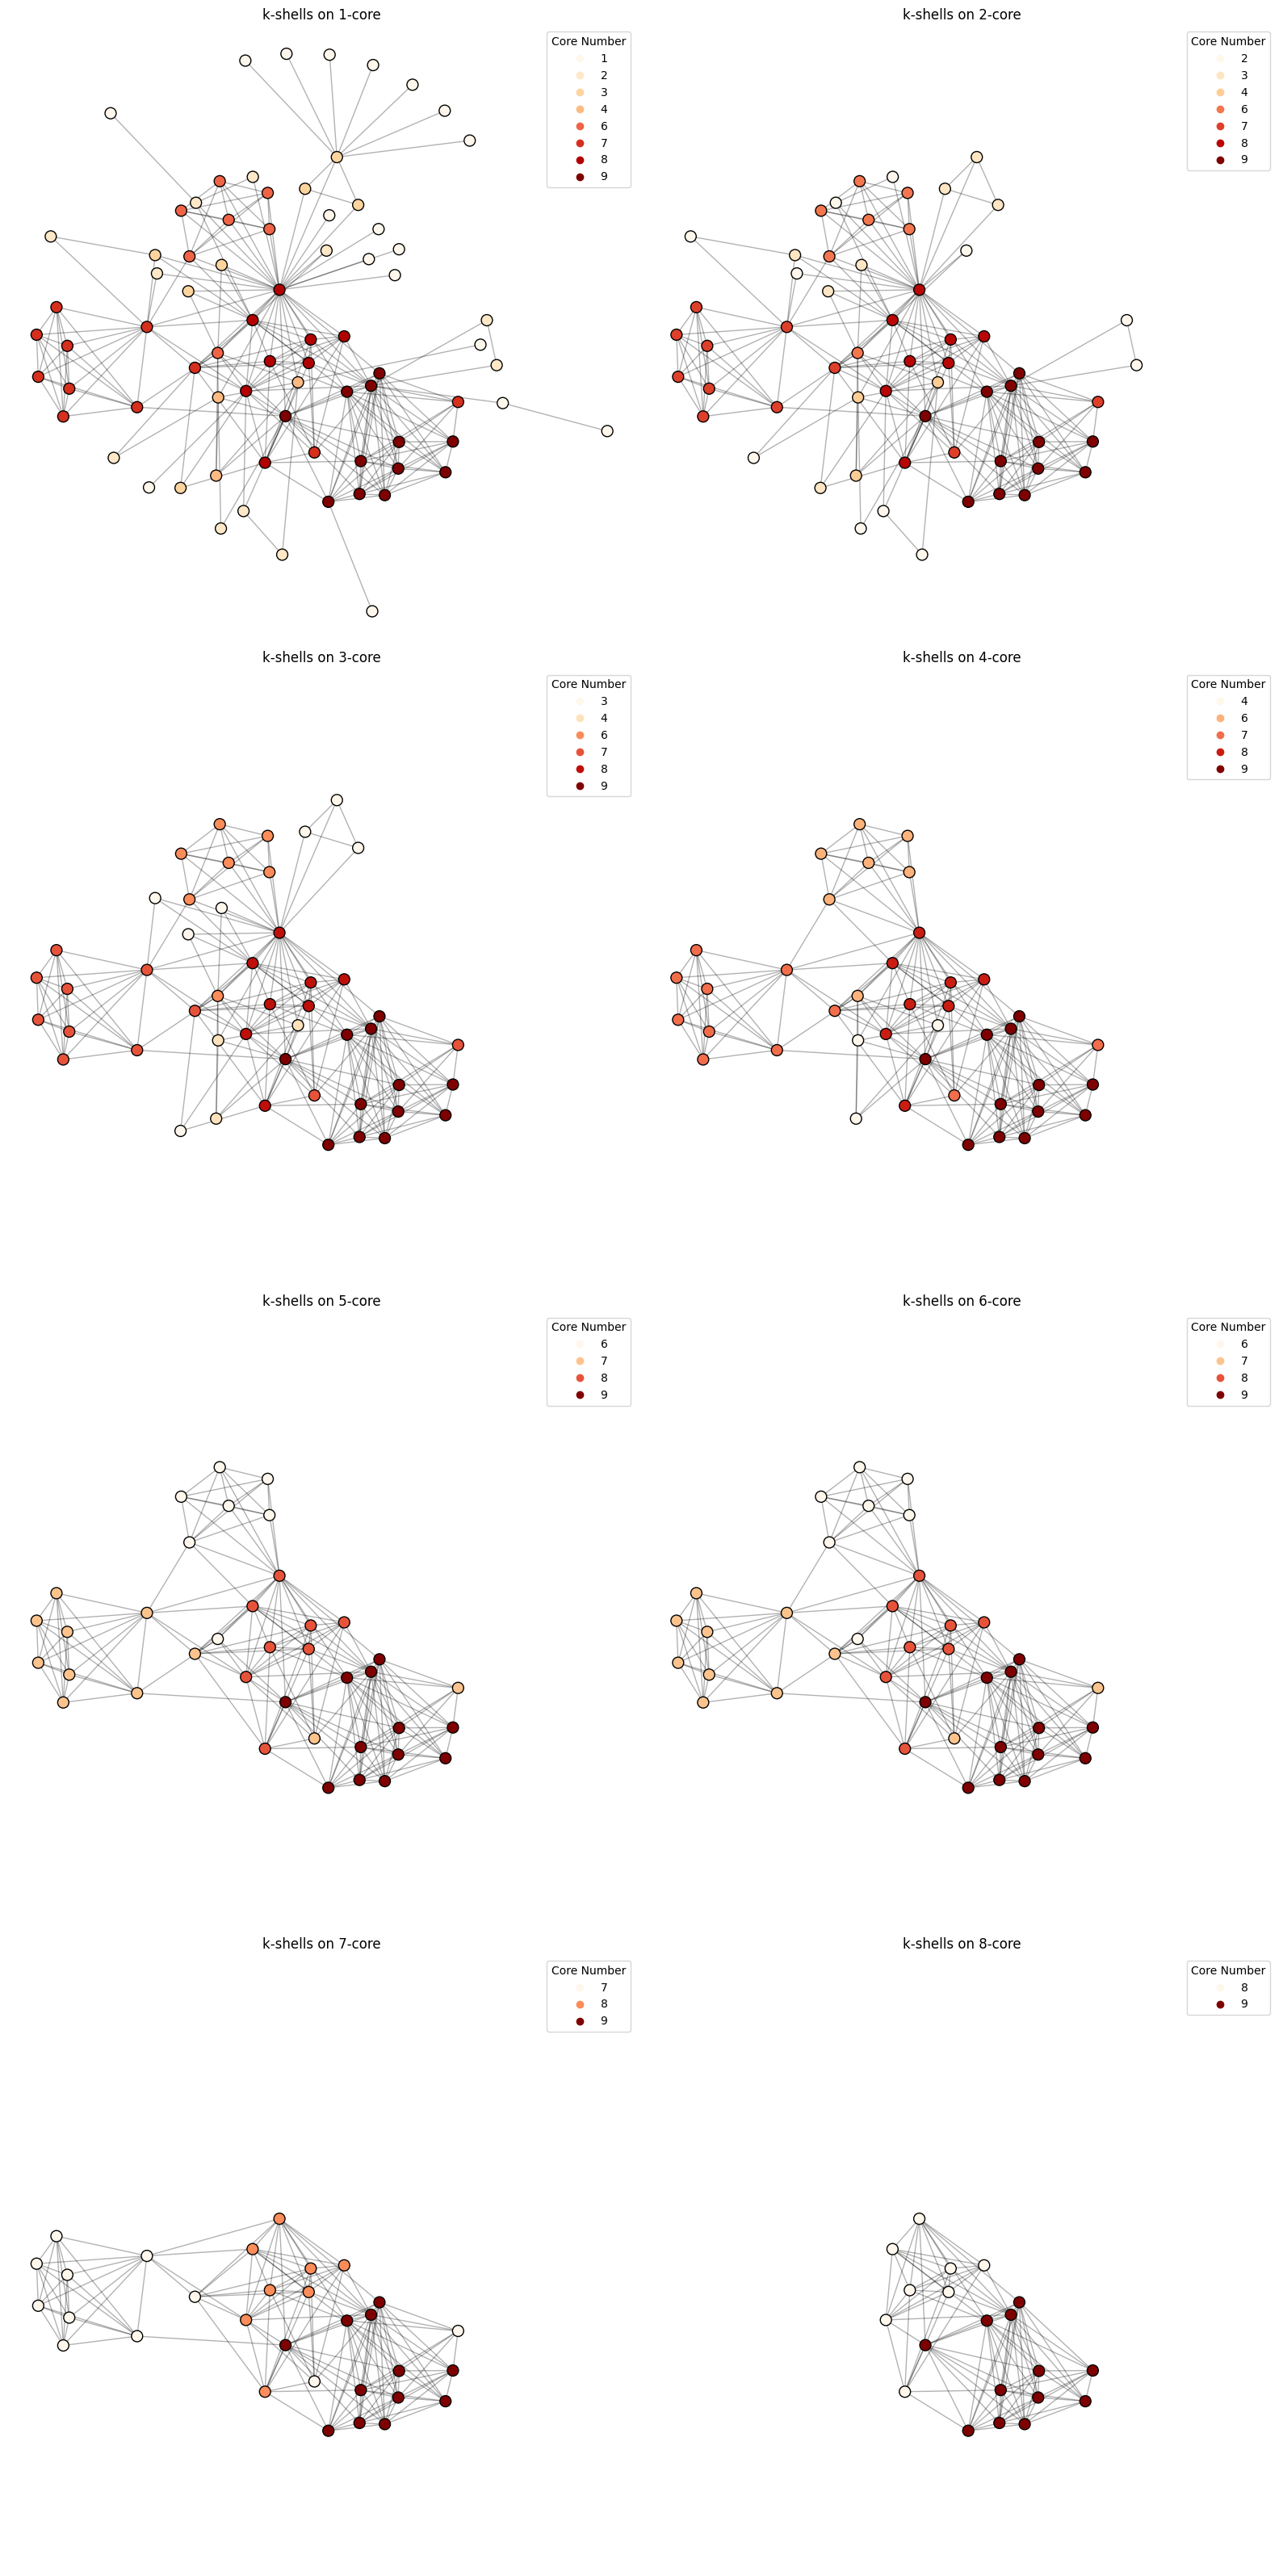

In [10]:
plt.figure(figsize=(16, 32))

positions = np.array(list(pos.values()))
x_min, y_min = positions.min(axis=0)
x_max, y_max = positions.max(axis=0)

for i in range(8):
    plt.subplot(4, 2, i + 1)
    subG = nx.k_core(G, i + 1)

    if len(subG) == 0:
        continue

    core_numbers = kcoreDecomposition(subG)

    nodes = nx.draw_networkx_nodes(
        subG,
        pos,
        cmap=plt.cm.OrRd,
        node_color=core_numbers,
        node_size=100,
        edgecolors='black'
    )

    nx.draw_networkx_edges(
        subG,
        pos,
        alpha=0.3,
        width=1,
        edge_color='black'
    )

    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min - eps, x_max + eps)
    plt.ylim(y_min - eps, y_max + eps)

    plt.legend(*nodes.legend_elements(), title="Core Number")
    plt.axis('off')

    plt.title(f'k-shells on {i + 1}-core')

plt.tight_layout()
plt.show()

Bạn có nhận xét gì?

## Task 2. Phát hiện đồ thị con hoàn chỉnh (Clique detection)

Đồ thị con hoàn chỉnh (complete subgraph) hay Clique, một mô hình đơn giản của một cộng đồng. Trong phần này, chúng ta sẽ thực hiện việc tìm kiếm những clique lớn nhất trong một đồ thị bằng sự hỗ trợ của `nx.find_cliques` và trực quan hóa chúng.

Để hoàn thành phần này, bạn cần hoàn thành hàm `largestCliques` mà nhận đầu vào là một đồ thị và nó thực hiện việc tìm kiếm các cliques lớn nhất với cùng kích thước. Việc lựa chọn màu sắc và chiều rộng (width) được thực hiện bởi luật như sau:
- Tất cả các đỉnh có màu `trắng` ngoại trừ đỉnh nằm trong clique lớn nhất.
- Tất cả các cạnh có độ rộng thon gọn (`thin`), rộng thon gọn bao nhiêu là tùy vào việc bạn chọn (tôi không quan tâm), ngoại trừ các cạnh nằm trong cliques thì nó phải dày hơn một chút.

Hàm này trả về một tuple với 2 mảng np.array như sau:
- Mảng `rgb` np.array có shape `[n,m,3]` trong đó `n` là số lượng cliques, `m` là số lượng đỉnh, `3(r, g, b)` là số lượng các giá trị nằm trong khoảng `[0, 1]` thể hiện cho bộ ba màu cơ bản `red`, `green`, và `blue`.
- Mảng `width` np.array có shape `[n,k]` trong đó `n` là số lượng cliques, `k` là số lượng cạnh.

Lưu ý: màu sắc được gán thứ tự bởi `G.nodes`, còn độ rộng được gán thứ tự bởi `G.edges`.

In [11]:
def largestCliques(G: nx.Graph) -> Tuple[np.ndarray, np.ndarray]:
    # YOUR CODE HERE
    cliques = list(nx.find_cliques(G))
    max_clique_size = max(len(clique) for clique in cliques)
    largest_cliques = [clique for clique in cliques if len(clique) == max_clique_size]

    rgb = np.ones((len(largest_cliques), len(G.nodes), 3))
    width = np.full((len(largest_cliques), len(G.edges)), 0.5)

    edge_list = list(G.edges)
    edge_dict = {tuple(sorted(edge)): i for i, edge in enumerate(edge_list)}

    for i, clique in enumerate(largest_cliques):
        for node in clique:
            node_idx = list(G.nodes).index(node)
            rgb[i, node_idx] = [1, 0, 0]  # Red color for nodes in the largest clique

        clique_edges = [(clique[u], clique[v]) for u in range(len(clique)) for v in range(u + 1, len(clique))]
        for edge in clique_edges:
            edge = tuple(sorted(edge))
            if edge in edge_dict:
                edge_idx = edge_dict[edge]
                width[i, edge_idx] = 2.0  # Thicker edges for the largest clique

    return rgb, width

In [12]:
# Test
colors, widths = largestCliques(G)
assert colors.shape == (2, 77, 3), "Colors array should have shape (2, 77, 3)"

unique_color_counts_0 = np.unique(colors[0], axis=0, return_counts=True)[1]
unique_color_counts_1 = np.unique(colors[1], axis=0, return_counts=True)[1]
assert unique_color_counts_0[0] == 10, "First unique color count in colors[0] should be 10"
assert unique_color_counts_1[0] == 10, "First unique color count in colors[1] should be 10"

matching_colors_condition = (colors.sum(axis=2) < 3)[0] & (colors.sum(axis=2) < 3)[1]
assert matching_colors_condition.sum() == 8, "Sum of matching color conditions should be 8"

assert widths.shape == (2, 254)
unique_width_counts_0 = np.unique(widths[0], axis=0, return_counts=True)[1]
unique_width_counts_1 = np.unique(widths[1], axis=0, return_counts=True)[1]
assert unique_width_counts_0[1] == 45, "Second unique width count in widths[0] should be 45"
assert unique_width_counts_1[1] == 45, "Second unique width count in widths[1] should be 45"

matching_widths_condition = (widths == widths.min())[0] & (widths == widths.min())[1]
assert matching_widths_condition.sum() == 192, "Sum of matching minimum widths condition should be 192"

Trực quan hóa

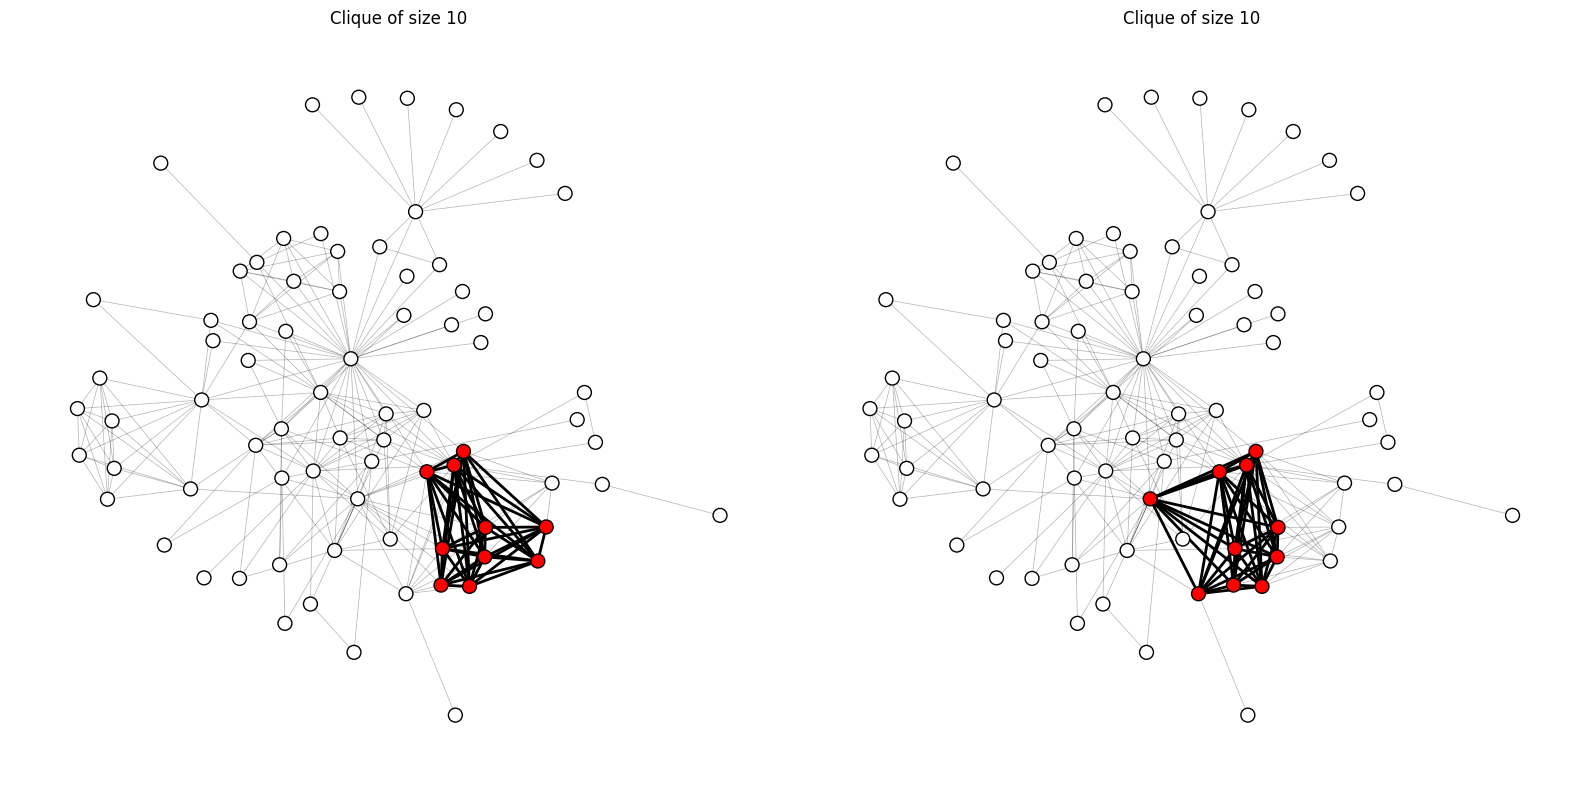

In [13]:
largest_clique_size = np.unique(colors[0], axis=0, return_counts=True)[1][0]

plt.figure(figsize=(16, 8))

for i in range(colors.shape[0]):
    max_width_edges = np.array(list(G.edges))[widths[i] == widths[i].max()]

    plt.subplot(1, 2, i + 1)

    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_color=colors[i],
        node_size=100,
        linewidths=1,
        edgecolors='black'
    )

    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.3,
        width=widths[i].min()
    )

    nx.draw_networkx_edges(
        G,
        pos,
        width=widths[i].max(),
        edgelist=max_width_edges
    )

    plt.title(f'Clique of size {largest_clique_size}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Bạn có nhận xét gì?

## Task 3. Thuật toán Girvan Newman và tính căn giữa cạnh (edge betweenness)

Lưu ý: Có nhiều tôi dịch thuật ngữ có thể còn thô và chưa được hay. Nếu các bạn có ý kiến đóng góp cách dịch hay hơn. Hãy cho tôi ý kiến đó. Thanks. (Nam Le)

Trong phần này, chúng ta sẽ áp dụng thuật toán Girvan Newman với tính căn giữa cạnh (edge betweenness). Ý tưởng ở đây là chúng ta cắt các cạnh với betweenness cao nhất cho đến khi nào mà đồ thị nó không còn liên thông nữa thì thôi. 

Để hoàn thành phần này, các bạn sử dụng `nx.algorithms.community.girvan_newman` để tìm kiếm các cộng đồng. Các bạn viết hàm `edgeBetweeness` mà nhận đầu vào là một đồ thị và số lượng các vết cắt (divisions) `n` và trả về mảng np.array các số nguyên thể hiện nhãn của đỉnh trong mỗi vòng lặp. Shape của đầu ra là `[n, m]` trong đó `n` là số lượng vòng lặp và `m` là số lượng đỉnh.

In [14]:
def edgeBetweenness(G: nx.Graph, n: int) -> np.ndarray:
    # YOUR CODE HERE
    communities_generator = nx.algorithms.community.girvan_newman(G)
    result = []
    
    for i, communities in enumerate(communities_generator):
        if i >= n:
            break
        labels = np.zeros(len(G.nodes), dtype=int)
        for j, community in enumerate(communities):
            for node in community:
                labels[list(G.nodes).index(node)] = j
        result.append(labels)
    
    return np.array(result)

In [15]:
# Test
labels = edgeBetweenness(G, 6)
assert labels.shape == (6, 77), "Labels array should have shape (6, 77)"
unique_labels_0 = np.unique(labels[0])
assert unique_labels_0.shape == (2,), "First partition should have 2 unique labels"
for i in range(1, 6):
    unique_labels_prev = np.unique(labels[i - 1])
    unique_labels_current = np.unique(labels[i])
    assert unique_labels_prev.shape[0] < unique_labels_current.shape[0], (f"Partition {i} should have more unique labels than partition {i-1}")
assert labels[5][22] == labels[5][23], "Labels at indices 22 and 23 in partition 5 should be equal"
assert labels[5][31] == labels[5][34], "Labels at indices 31 and 34 in partition 5 should be equal"

Trực quan hóa

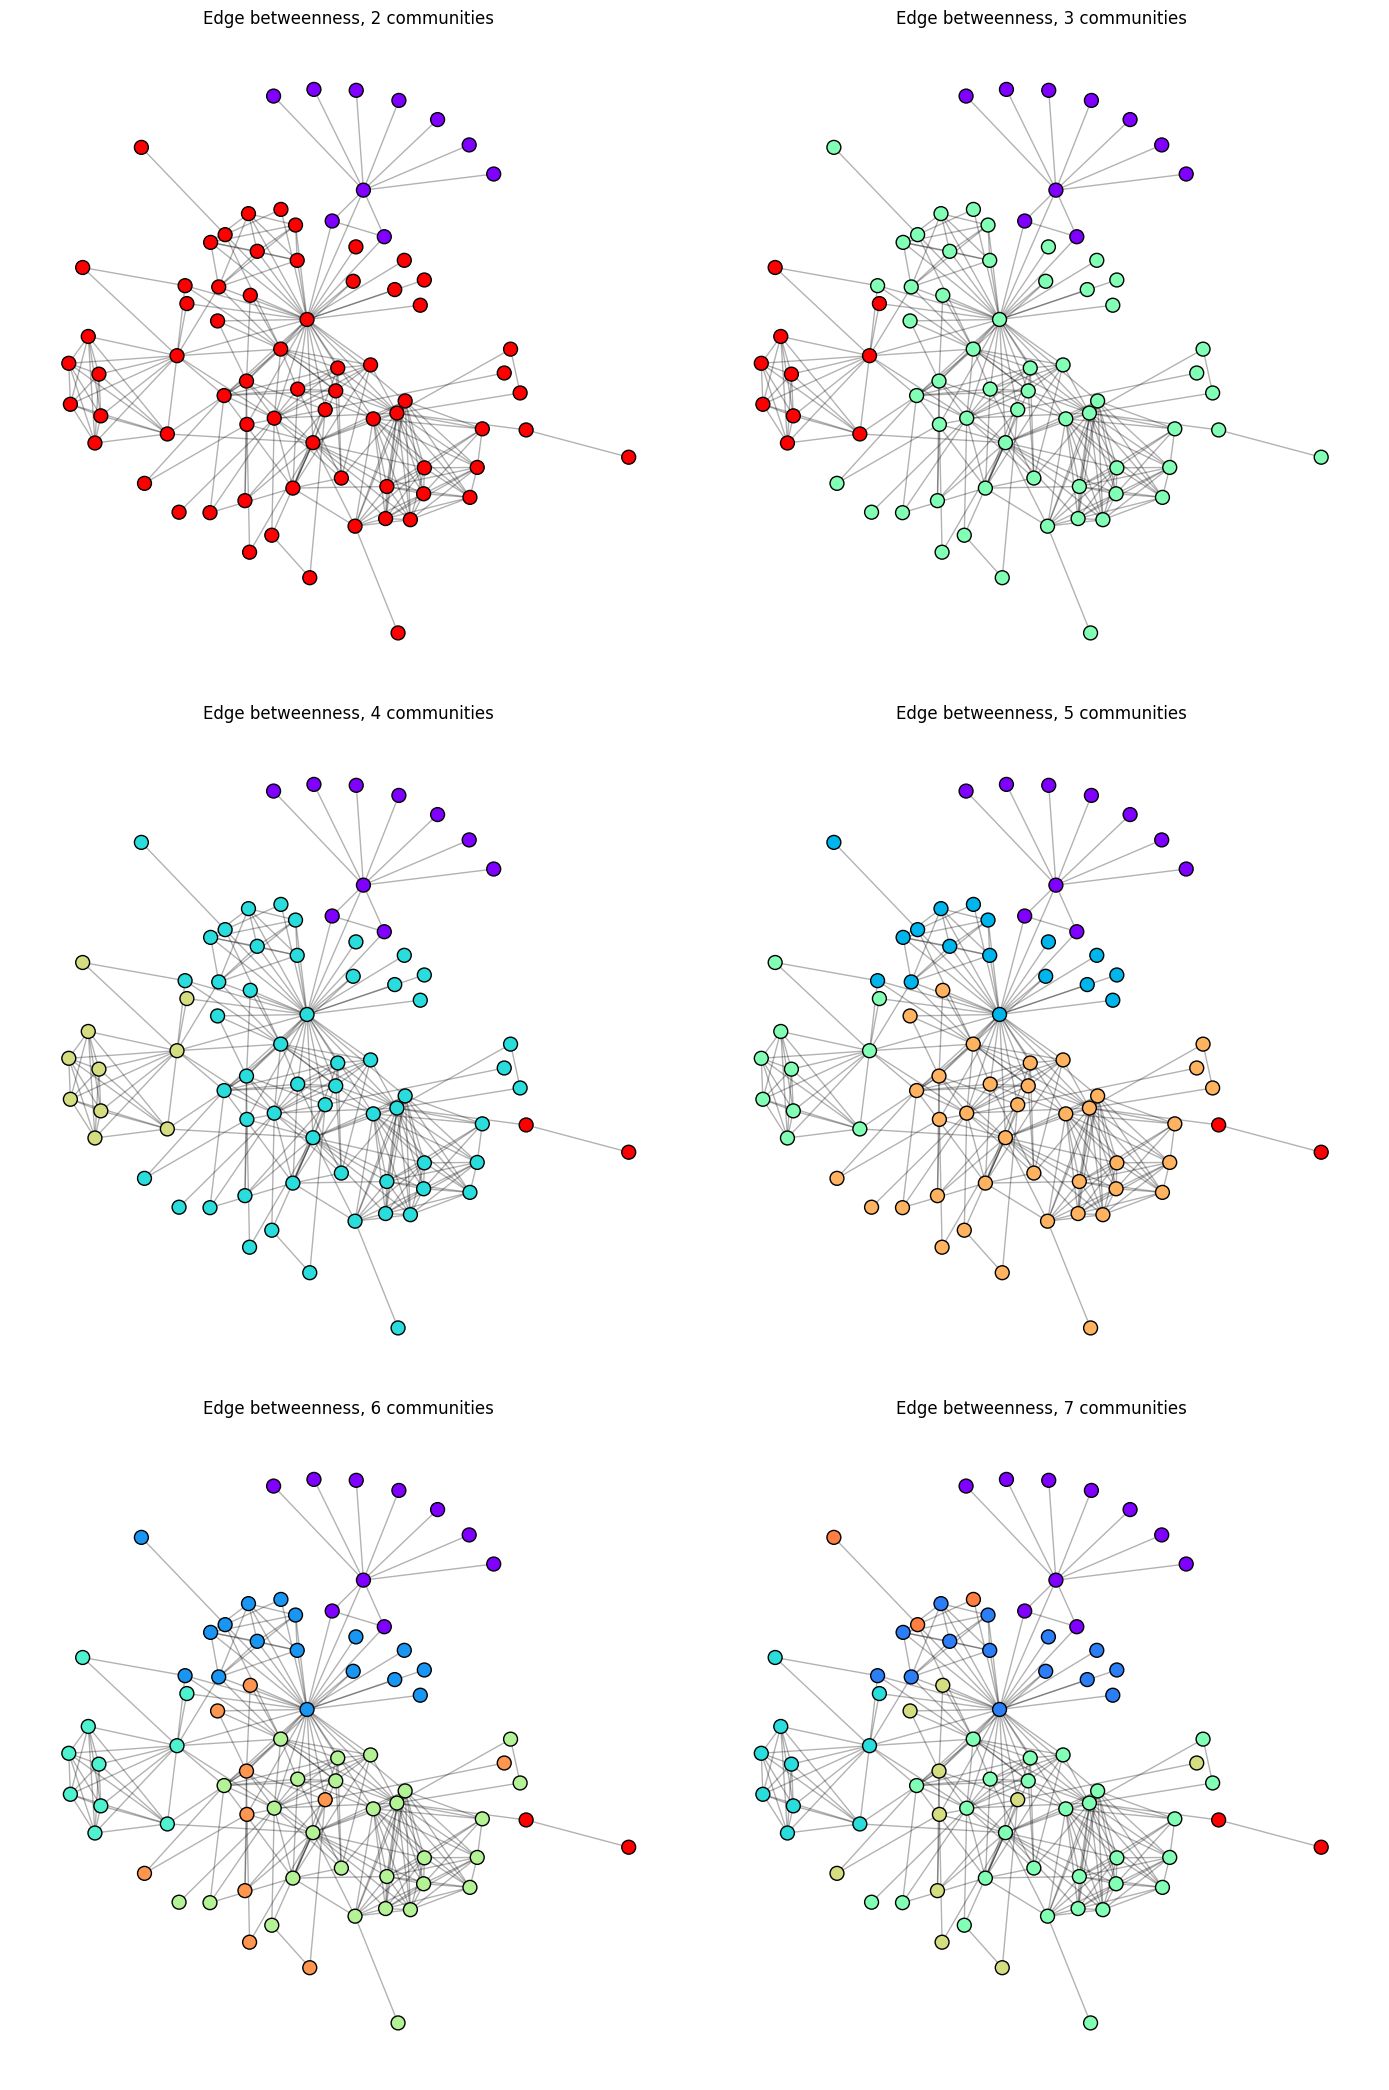

In [16]:
colors = edgeBetweenness(G, 6)

plt.figure(figsize=(14, 21))

for i in range(colors.shape[0]):
    plt.subplot(3, 2, i + 1)

    nx.draw_networkx_nodes(
        G,
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors[i],
        node_size=100,
        edgecolors='black'
    )

    nx.draw_networkx_edges(G, pos, alpha=0.3)

    plt.title(f'Edge betweenness, {i + 2} communities')
    plt.axis('off')

plt.tight_layout()
plt.show()

Bạn có nhận xét gì?

## Task 4. Mô-đun hóa (Modularity)

Mô-đun hóa (Modularity) giúp ta quyết định khi nào dừng phân hoạch đồ thị. Mô-đun hóa càng lớn, phân hoạch càng tốt (đọc sách Network science). Bây giờ, ta sẽ xem mô-đun hóa thay đổi như thế trong quá trình phân chia đồ thị.

Trong phần này, bạn chỉ cần hoàn thành hàm `edgeBetweennessModularity` mà nhận đầu vào là một đồ thị, số lượng bước lặp của thuật toán Girvan Newman, và trả về một mảng np.array với modularity thu được sau khi hoàn thành mỗi vòng lặp. Bạn có thể sử dụng `nx.algorithms.community.modularity`.


In [17]:
def edgeBetweennessModularity(G: nx.Graph, n: int) -> np.ndarray:
    # YOUR CODE HERE
    communities_generator = nx.algorithms.community.girvan_newman(G)
    modularity_values = []
    
    for i, communities in enumerate(communities_generator):
        if i >= n:
            break
        communities_list = [list(community) for community in communities]
        modularity = nx.algorithms.community.modularity(G, communities_list)
        modularity_values.append(modularity)
    
    return np.array(modularity_values)

In [18]:
# Test
n_iterations = 20
modularity = edgeBetweennessModularity(G, n_iterations)
assert modularity.shape == (n_iterations,), "Modularity array should have shape (20,)"
assert round(modularity[0], 4) == 0.0746, "Modularity at index 0 should be 0.0746"
assert round(modularity[7], 4) == 0.4519, "Modularity at index 7 should be 0.4519"

Trực quan hóa

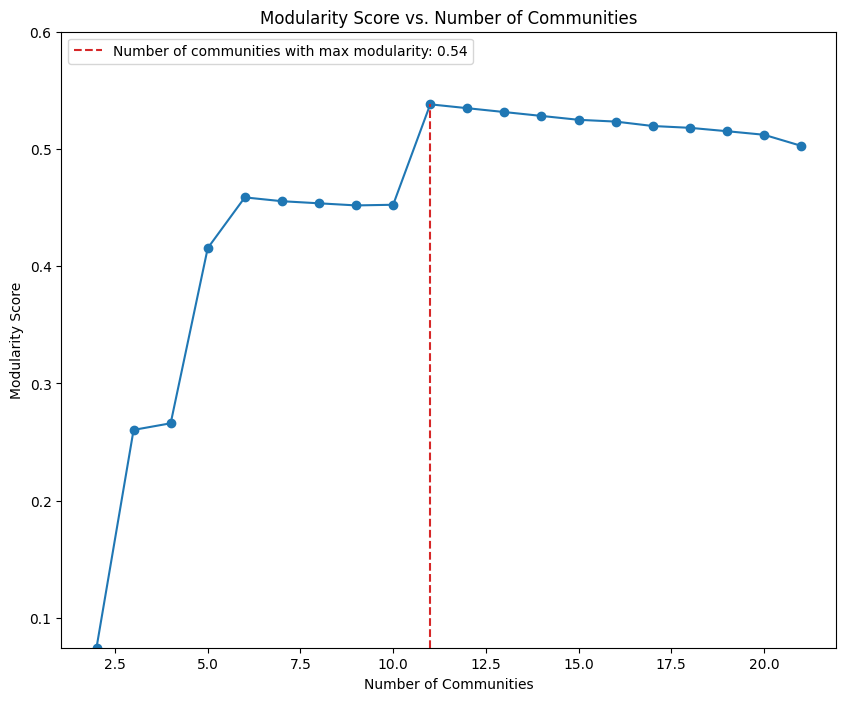

In [19]:
plt.figure(figsize=(10, 8))

plt.plot(np.arange(n_iterations) + 2, modularity, marker='o')

best_n = np.argmax(modularity) + 2
max_modularity = max(modularity)
label = f'Number of communities with max modularity: {max_modularity:.2f}'

plt.plot(
    [best_n, best_n], [min(modularity), max_modularity],
    linestyle='--', color='tab:red',
    label=label
)

plt.ylabel('Modularity Score')
plt.xlabel('Number of Communities')
plt.title('Modularity Score vs. Number of Communities')
plt.legend(loc='upper left')

plt.ylim(modularity.min(), 0.6)

plt.show()

Bạn có nhận xét gì?

## Task 5. Trị riêng (Eigenvalues) của đồ thị Laplacian

Chúng ta cần một số hàm phục vụ cho việc phát sinh đồ thị.

In [20]:
def ringLattice(n: int, k: int) -> nx.Graph:
    """Hàm tạo đồ thị vòng.

    Parameters
    ----------
    n
        (int) số lượng đỉnh cho trước
    k
        (int) bậc đỉnh

    Returns
    -------
        (nx.Graph) đồ thị kết quả
    """
    G = nx.Graph()
    nodes = list(range(n))
    for i in range(1, int(k/2 + 1)):
        targets = nodes[i:] + nodes[:i]
        G.add_edges_from(zip(nodes, targets))
    return G

In [21]:
def pairGraph(n):
    """Hàm tạo đồ thị đôi

    Parameters
    ----------
    n
        (int) số lượng đỉnh cho trước

    Returns
    -------
        (nx.Graph) đồ thị kết quả
    """
    G = nx.disjoint_union(nx.complete_graph(n), nx.complete_graph(n))
    G.add_edge(0, n)
    return G

In [22]:
def tripleGraph(n):
    """Hàm tạo đồ thị cặp ba

    Parameters
    ----------
    n
        (int) số lượng đỉnh cho trước

    Returns
    -------
        (nx.Graph) đồ thị kết quả
    """
    G = nx.disjoint_union_all(
        [nx.complete_graph(n), nx.complete_graph(n), nx.complete_graph(n)]
    )
    G.add_edge(0, n)
    G.add_edge(n, n*2)
    G.add_edge(n*2, 0)
    return G

Đồ thị Laplacian có công thức như sau:

$$L = D - A$$

trong đó $A$ là một ma trận kề, $D$ là ma trận đường chéo với các bậc đỉnh. Trị riêng và vector riêng của Laplacian có thể cho chúng ta biết thông tin về cấu trúc của một đồ thị. Ta sẽ xem xét một vài ví dụ đơn giản để hiểu phát biểu này.


Trong phần này, bạn hoàn thành một hàm `eigenLaplacian` mà nhận đầu vào là một đồ thị và trả về một tuple gồm hai mảng numpy array: `eigenvectors` và `eigenvalues` thể hiện cho vector riêng và trị riêng của Laplacian. Cả hai thành phần này được xếp theo thứ tự giảm dần của trị riêng.

_Gợi ý: bất kỳ ma trận đối xứng nào chỉ có trị riêng và vector riêng thực. Bạn có thể sử dụng `np.linalg.eigh` để tính toán các vector riêng và trị riêng trong một ma trận đối xứng._

In [23]:
def eigenLaplacian(G: nx.Graph) -> Tuple[np.ndarray, np.ndarray]:
    # YOUR CODE HERE
    # Calculate the Laplacian matrix
    L = nx.laplacian_matrix(G).toarray()
    
    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    
    # Sort eigenvalues and corresponding eigenvectors in ascending order
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    return eigenvectors, eigenvalues

In [24]:
# Test
emptyG = nx.empty_graph(10)
vecs, vals = eigenLaplacian(emptyG)
assert vecs.sum() == 10, "Sum of eigenvectors should be 10 for empty graph"
assert vals.sum() == 0, "Sum of eigenvalues should be 0 for empty graph"

oneedgeG = nx.empty_graph(10)
oneedgeG.add_edge(0, 1)
vecs, vals = eigenLaplacian(oneedgeG)

assert abs(vecs.round(4)[0, -1]) == abs(vecs.round(4)[1, -1]) == 0.7071, ("Eigenvector values at indices 0 and 1 should be 0.7071")
assert vals[0] < vals[-1], "First eigenvalue should be less than the last eigenvalue"


completeG = nx.complete_graph(10)
vecs, vals = eigenLaplacian(completeG)
assert (vals == vals.real).sum() == vals.shape[0], "All eigenvalues should be real"
assert (vecs == vecs.real).sum() == vals.shape[0]**2, "All eigenvectors should be real"

ringG = ringLattice(10, 2)
vecs, vals = eigenLaplacian(ringG)
assert adler32(vals.round(4)[-1]) == 6815825, "Checksum of last eigenvalue should match"
assert adler32(vals.round(4)[-2]) == 393479360, "Checksum of second last eigenvalue should match"

Trực quan hóa một số đồ thị đơn giản và trị riêng Laplacian của chúng.

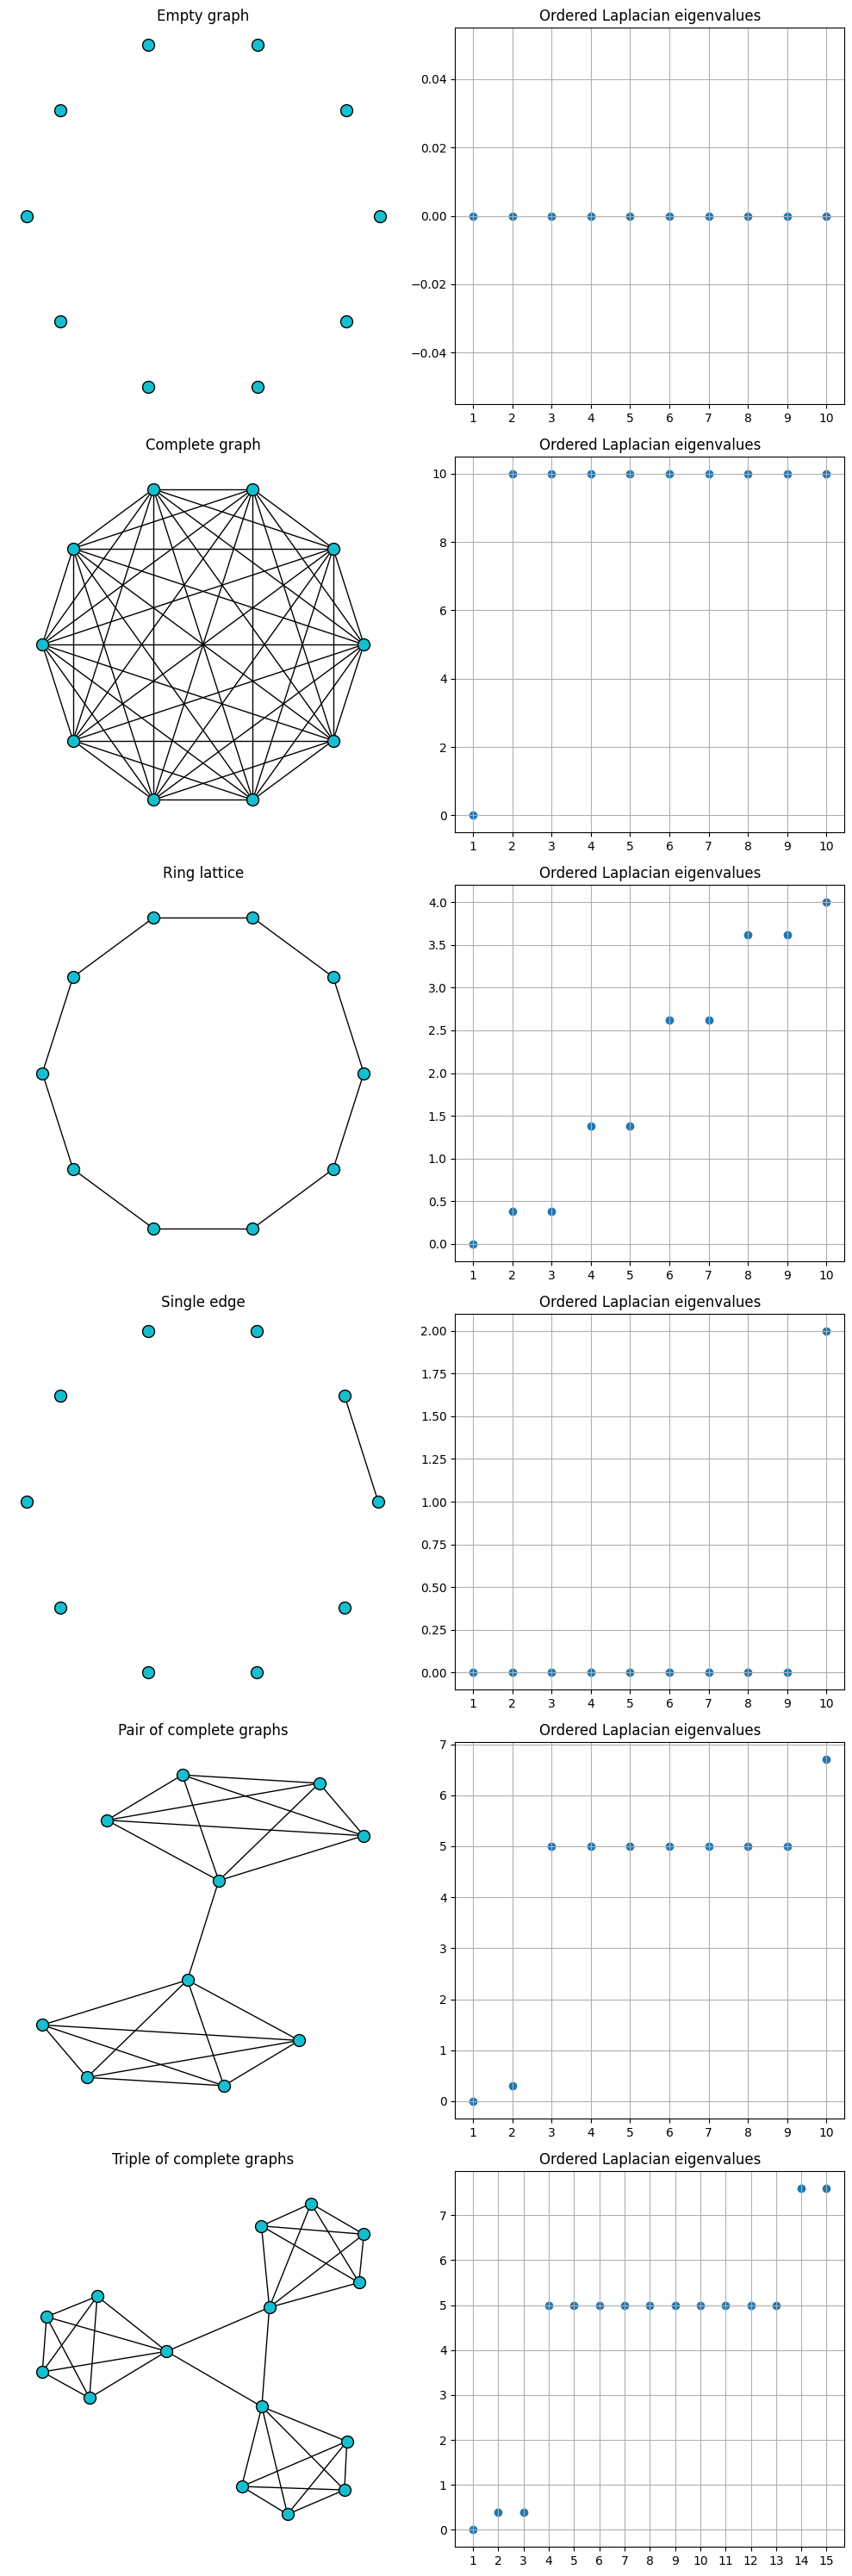

In [25]:
cases = [
    (emptyG, 'Empty graph', nx.draw_circular),
    (nx.complete_graph(10), 'Complete graph', nx.draw_circular),
    (ringLattice(10, 2), 'Ring lattice', nx.draw_circular),
    (oneedgeG, 'Single edge', nx.draw_circular),
    (pairGraph(5), 'Pair of complete graphs', nx.draw_kamada_kawai),
    (tripleGraph(5), 'Triple of complete graphs', nx.draw_kamada_kawai)
]

plt.figure(figsize=(10, 30))

for i, (graph, title, layout) in enumerate(cases, 1):
    plt.subplot(6, 2, 2*i-1)
    layout(graph, node_color='tab:cyan', edgecolors='black', node_size=100)
    plt.title(title)
    plt.axis('off')

    plt.subplot(6, 2, 2*i)
    vecs, vals = eigenLaplacian(graph)
    plt.scatter(np.arange(1, len(graph) + 1), vals)
    plt.grid(True)
    plt.xticks(np.arange(1, len(graph) + 1))
    plt.title('Ordered Laplacian eigenvalues')

plt.tight_layout()
plt.show()

Bạn có nhận xét gì?

## Task 6. Gom cụm phổ (Spectral clustering)

Gom cụm phổ hay Spectral clustering là một thuật toán mạnh mẽ phục vụ cho tác vụ phát hiện cộng đồng mà dựa trên việc cực tiểu lát cắt đồ thị. Nó dựa trên vector riêng Laplacian, một cách nói cụ thể hơn, dấu của vector riêng nhỏ thứ hai quyết định phân hoạch đồ thị thành hai cụm.

Trong phần này, ta xem xét một dataset nhân tạo dạng đường tròn như sau:

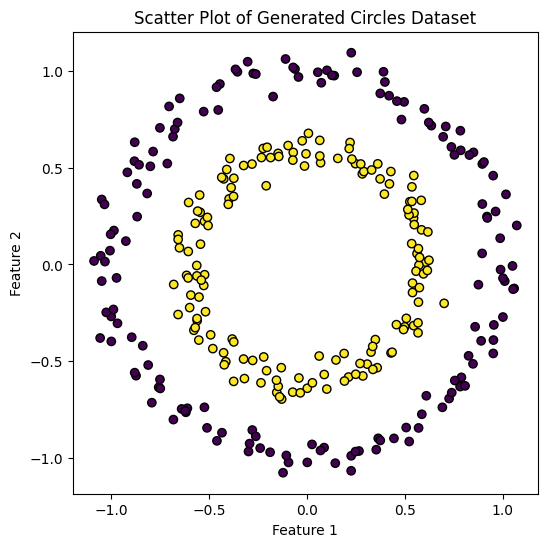

In [26]:
from sklearn import datasets

circles, truth_labels = datasets.make_circles(
    n_samples=300, factor=0.6, noise=0.05, random_state=0
)

plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1], c=truth_labels,
            cmap='viridis', edgecolor='k')
plt.title('Scatter Plot of Generated Circles Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Chúng ta hãy cô lập các điểm dữ liệu trong vòng tròn trung tâm bằng cách sử dụng gom cụm phổ. Bất kỳ tập dữ liệu dựa trên khoảng cách nào cũng có thể được biểu diễn dưới dạng đồ thị có các cạnh giữa các lân cận.

Bạn cần hoàn thành hàm `customGraph` mà nhận đầu vào là một mảng np.array với các điểm tọa độ x-y và trả về một đồ thị liên thông.

_Gợi ý: bạn thử áp dụng hàm `sklearn.neighbors.kneighbors_graph`_

_Nhận xét: bạn có thể đề xuất sử dụng khoảng cách của riêng bạn!_

In [27]:
from sklearn.neighbors import kneighbors_graph

def customGraph(data: np.ndarray) -> nx.Graph:
  # YOUR CODE HERE
    k = 10  # Choose the value of k 
    knn_graph = kneighbors_graph(data, n_neighbors=k, mode='connectivity', include_self=False)
    
    G = nx.from_scipy_sparse_array(knn_graph)
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        for i in range(1, len(components)):
            G.add_edge(list(components[0])[0], list(components[i])[0])
    
    return G


In [28]:
# Test
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
circlesG = customGraph(circles)
assert circlesG.number_of_nodes() == 300, "The graph should have 300 nodes"
assert nx.is_connected(circlesG), "The graph should be connected"

Trực quan hóa giá trị trong vector riêng nhỏ thứ hai của Laplacian.

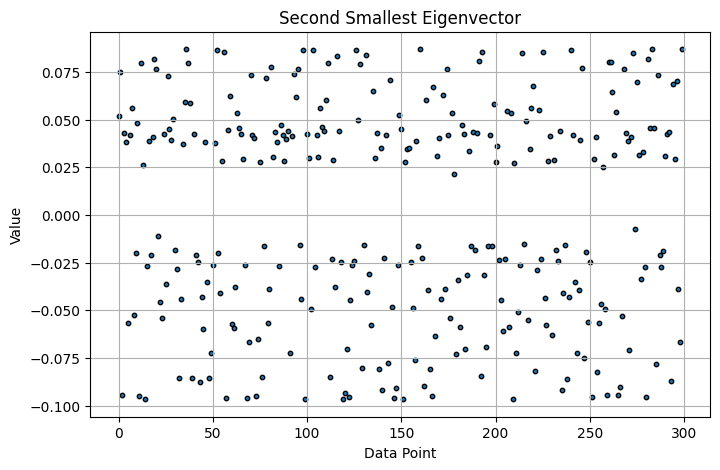

In [29]:
vecs, vals = eigenLaplacian(circlesG)

plt.figure(figsize=(8, 5))
plt.scatter(np.arange(300), vecs[:, 1], s=10, color='tab:blue', edgecolor='k')
plt.title('Second Smallest Eigenvector')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Kế tiếp, bạn viết một hàm `spectralTwoClusters` mà nhận đầu vào là một mảng np.array vector riêng có thứ tự và trả về mảng np.array nhãn của các đỉnh. 

In [30]:
def spectralTwoClusters(vecs: np.ndarray) -> np.ndarray:
    # YOUR CODE HERE
    fiedler_vector = vecs[:, 1]
    labels = np.where(fiedler_vector > 0, 1, 0)
    return labels

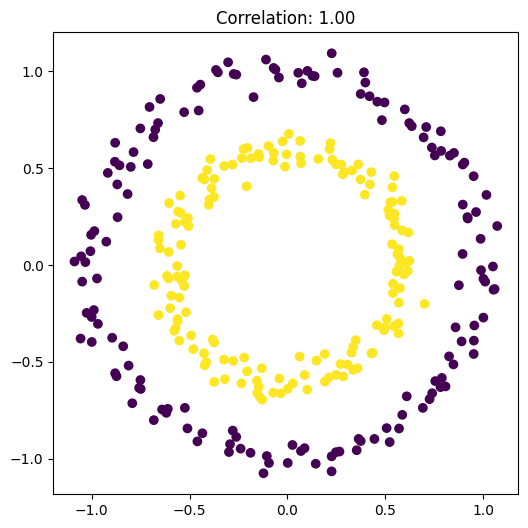

In [31]:
# Test
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
circlesG = customGraph(circles)
vecs, vals = eigenLaplacian(circlesG)
labels = spectralTwoClusters(vecs)

assert abs(np.corrcoef(truth_labels, labels)[0, 1]) > 0.95

plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1], c=labels)
plt.title('Correlation: {:.2f}'.format(abs(np.corrcoef(truth_labels, labels)[0, 1])))
plt.show()

Bạn có nhận xét gì?

_Ghi chú: ở đây có hai hướng trong xây dựng đồ thị: 1) lựa chọn các cặp đỉnh để liên kết lại với nhau, và 2) chọn trọng số trong việc khởi tạo cạnh. Hãy thử gán tham số `factor=0.7` trong `datasets.make_circles` và kiểm tra lại một lần nữa để đạt được tương quan 0.9. Kết hợp `sklearn.neighbors.kneighbors_graph` với `scipy.spatial.distance_matrix` hay `sklearn.metrics.pairwise.rbf_kernel`. Nếu bạn quan tâm, hãy đọc phân tích chi tiết [ở đây]((http://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf))_

Sau khi thực hiện xong phần ghi chú, bạn để lại nhận xét của bạn ở phía dưới (phần này không tính điểm, chỉ mang tính chất điểm cộng).

## Task 7. Các ánh xạ trị riêng Laplacian (Laplacian Eigenmaps)

Trong task trước, ta đã thấy cách để mà phân chia một đồ thị thành hai phần. Bây giờ, chúng ta xem xét một cách để có nhiều phân hoạch hơn trong một đồ thị như sau:

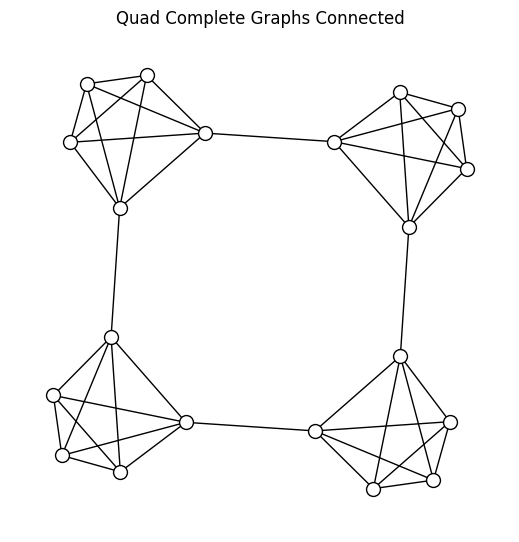

In [32]:
quadG = nx.disjoint_union_all([nx.complete_graph(5), 
                               nx.complete_graph(5),
                               nx.complete_graph(5),
                               nx.complete_graph(5)])

quadG.add_edge(0, 5)
quadG.add_edge(6, 10)
quadG.add_edge(11, 16)
quadG.add_edge(17, 1)

plt.figure(figsize=(5, 5))

nx.draw_kamada_kawai(
    quadG, 
    node_color='white', 
    edgecolors='black', 
    node_size=100
)

plt.title('Quad Complete Graphs Connected')

plt.show()

Việc phân hoạch hơn nữa có thể được thực hiện bằng nhiều hướng tiếp cận khác nhau. Ví dụ như, ta có thể lặp lại thủ tục gom cụm trên các hai đồ thị con phân biệt và chọn một lát cắt đồ thị nhỏ nhất và sau đó tiếp tục lặp lại. Một cách khác là lấy ánh xạ trị riêng Laplacian và áp dụng K-means. Ta sẽ xem cách này hoạt động như thế nào:

1. Tính toán Laplacian chuẩn hóa dựa trên công thức
$$L = D^{-1/2}(D - A)D^{-1/2}$$
2. Xếp chồng các vector riêng  $L$ thành ma trận $(x_1, x_2, \dots)$ theo chiều giảm dần giá trị của các trị riêng.
3. Nhân dòng $i$-th bởi $\frac{1}{\sqrt{d_i}}$ trong đó $d_i$ là bậc của đỉnh $i$
* $k$ của ma trận tính từ dòng thứ hai này trở đi được gọi là vector _Laplacian Eigenmaps (hay còn gọi là Spectral Embedding)_
4. Ném các eigenmaps này vào Kmeans.
5. Các nhãn đỉnh được khớp bởi Kmeans.

Bây giờ, bạn viết một hàm `normLaplacian` mà nhận đầu vào là một ma trận kề $A$ và trả về một tuple với hai mảng numpy. Mảng đầu tiên là ma trận Laplacian đã được chuẩn hóa, mảng còn lại là một chuỗi bậc đỉnh.


In [33]:
def normLaplacian(A: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # YOUR CODE HERE
    # Tính bậc của các đỉnh
    degree_seq = np.sum(A, axis=1)
    
    # Tạo ma trận đường chéo D
    D = np.diag(degree_seq)
    
    # Tạo ma trận đường chéo D^-1/2
    D_inv_sqrt = np.diag(1.0 / np.sqrt(degree_seq))
    
    # Tính ma trận Laplacian chuẩn hóa
    L = np.identity(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
    
    return L, degree_seq

In [34]:
# Test
A = nx.to_numpy_array(quadG)
L, degree_seq = normLaplacian(A)

assert degree_seq.shape == (20,), "Degree sequence should have 20 elements"
assert L.shape == (20, 20), "Laplacian matrix should be 20x20"
assert np.diagonal(L).sum() == 20, "Sum of the diagonal elements should be 20"
assert round(L[:, 2].sum(), 4) == 0.0528, ("Sum of the elements in the 3rd column should be 0.0528")

Tiếp theo, bạn hoàn thành hàm `spectralEmbedding` mà nhận đầu vào  mảng np.array `L` là Laplacian đã được chuẩn hóa, `degree_seq` là chuỗi bậc đỉnh, và `n_components` là số lượng vector đầu ra. Hàm này trả về một mảng np.array các Eigenmaps Laplacian

In [35]:
def spectralEmbedding(L: np.ndarray, degree_seq: np.ndarray, n_components: int) -> np.ndarray:
    vals, vecs = np.linalg.eigh(L)
    X = vecs * (1/np.sqrt(degree_seq))
    X = X[:, 1:n_components+1]
    return X

In [36]:
# Test
embedding = spectralEmbedding(L, degree_seq, 3)
assert embedding.shape == (20, 3), "Embedding matrix should be 20x3"

assert embedding[:, 0].max(
) > 0, "Max value in the first dimension should be > 0"
assert embedding[:, 0].min(
) < 0, "Min value in the first dimension should be < 0"
assert embedding[:, 1].max(
) > 0, "Max value in the second dimension should be > 0"
assert embedding[:, 1].min(
) < 0, "Min value in the second dimension should be < 0"

assert (embedding[:, 0] > 0).sum(
) == 10, "Number of positive values in the first dimension should be 10"
assert (embedding[:, 1] > 0).sum(
) == 10, "Number of positive values in the second dimension should be 10"
assert (embedding[:, 2] > 0).sum(
) == 10, "Number of positive values in the third dimension should be 10"

Giờ chúng ta ngắm nhìn vào một cặp biểu đồ của spectral embedding.

Ta định nghĩa hàm `spectralClustering` để thực hiện gom cụm.

In [37]:
def spectralClustering(G: nx.Graph, n_clusters: int, n_components: int) -> np.ndarray:
    """Thực hiện gom cụm phổ với một đồ thị đầu vào.

    Parameters
    ----------
    G
        (nx.Graph) Đồ thị đầu vào.
    n_clusters
        (int) Số lượng clusters.
    n_components
        (int) Số lượng thành phần trong spectral embedding.

    Returns
    -------
        (np.ndarray) Một mảng nhãn cụm cho mỗi nút.
    """
    A = nx.to_numpy_array(G)
    L, degree_seq = normLaplacian(A)
    embedding = spectralEmbedding(L, degree_seq, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

In [38]:
embedding = spectralEmbedding(L, degree_seq, 3)
labels = spectralClustering(quadG, 4, 3)
assert np.all(labels[:5] == labels[0]), "First complete graph nodes have different labels"
assert np.all(labels[5:10] == labels[5]), "Second complete graph nodes have different labels"
assert np.all(labels[10:15] == labels[10]), "Third complete graph nodes have different labels"
assert np.all(labels[15:20] == labels[15]), "Fourth complete graph nodes have different labels"

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x1000 with 0 Axes>

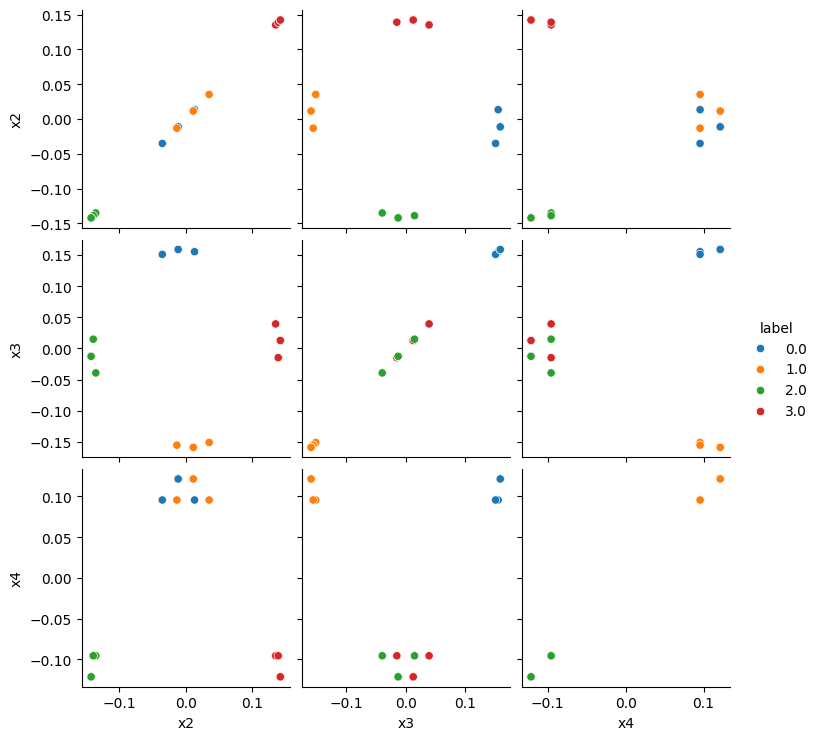

In [39]:
embedding = spectralEmbedding(L, degree_seq, 3)
labels = spectralClustering(quadG, 4, 3)

pair_data = pd.DataFrame(
    np.hstack([embedding, labels[:, None]]), 
    columns=['x2', 'x3', 'x4', 'label']
)

pair_data['label'] = pair_data['label'].astype('category')

plt.figure(figsize=(10, 10))

pairplot = sns.pairplot(
    pair_data,
    hue='label',
    diag_kind=None
)

# pairplot._legend.remove()

plt.show()

Chúng ta có thể thấy bốn cụm riêng biệt trong các ô, đó là lý do tại sao chúng ta lại sử dụng KMeans, nhưng các thuật toán phân cụm khác cũng có thể được áp dụng ở đây.

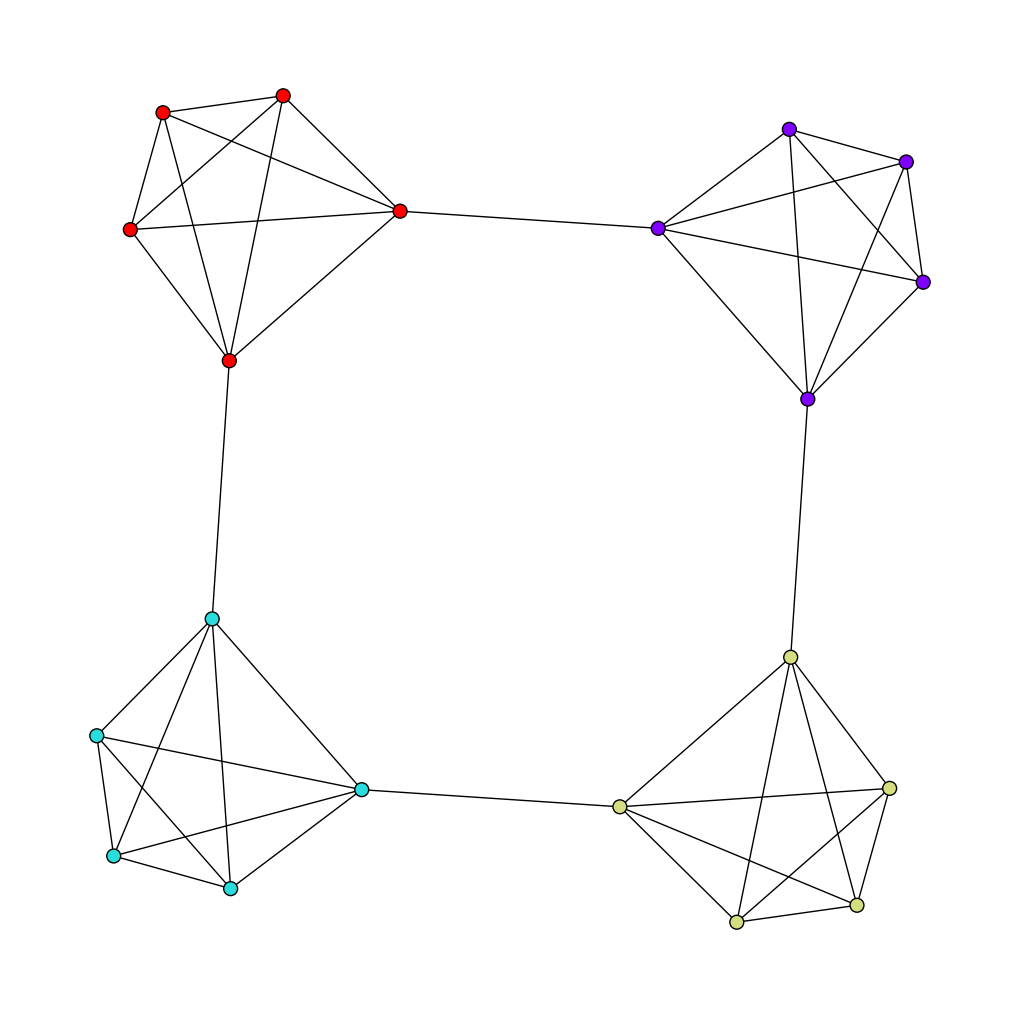

In [40]:
plt.figure(figsize=(10, 10))
nx.draw_kamada_kawai(
    quadG, 
    cmap=plt.cm.rainbow,
    node_color=labels, 
    edgecolors='black', 
    node_size=100)

Và bây giờ, ta xem thử spectral clustering hoạt động như thế nào trên đồ thị Les Miserables.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


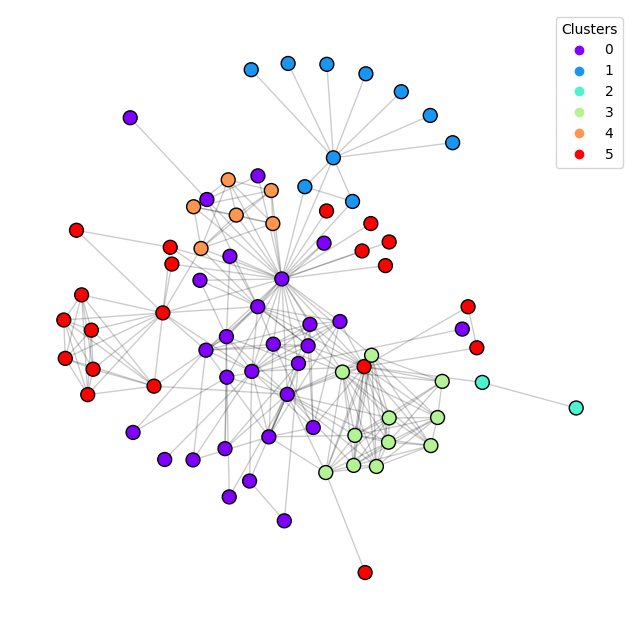

In [41]:
plt.figure(figsize=(8, 8))

node_colors = spectralClustering(G, 6, 5)

nodes = nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=node_colors, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)

nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)

plt.axis('off')

plt.legend(*nodes.legend_elements(), title="Clusters")

plt.show()

Bạn có nhận xét gì?

## Task 8. Gọm cụm kết tụ (Agglomerative clustering)

Gom cụm kết tục là một thủ tục lặp đi lặp lại, liên kết các cụm tương tự bằng cách sử dụng ma trận tương đồng. Trong bài tập này, bởi vì chúng ta sử dụng `sklearn.cluster.AgglomerativeClustering` nên chúng ta cần truyền vào một ma trận _khoảng cách_ Do đó, trước tiên ta cần chọn một độ đo tương đồng và sau đó chuyển đổi nó về một khoảng cách. Bây giờ, chúng ta sẽ thực hiện nó thông qua độ đo SimRank mà được định nghĩa như sau: _hai đối tượng được xem là giống nhau (gần nhau) nếu chúng được tham chiếu bởi những đối tượng giống nhau._ Bởi vì SimRank có giá trị nằm trong khoảng [0, 1], nên ta sẽ định nghĩa một khoảng cách như sau:
$$\text{Distance}= 1 - \text{SimRank}$$

Bây giờ bạn hoàn thành một hàm `simrankDistance` mà nhận đầu vào là một đồ thị và trả về một ma trận khoảng cách dựa trên SimRank. Sử dụng `nx.simrank_similarity` để tính giá trị SimRank và sau đó chuyển đổi về mảng numpy. Ma trận khoảng cách nên đối xứng _một cách tuyệt đối_.

In [42]:
def simrankDistance(G: nx.Graph) -> np.ndarray:
    # YOUR CODE HERE
    # Tính toán ma trận SimRank
    simrank_dict = nx.simrank_similarity(G)
    
    # Khởi tạo ma trận khoảng cách
    n = len(G.nodes)
    distance = np.zeros((n, n))
    
    # Lấy danh sách các đỉnh
    nodes = list(G.nodes)
    
    # Điền giá trị khoảng cách vào ma trận
    for i in range(n):
        for j in range(n):
            if i != j:
                simrank = simrank_dict[nodes[i]].get(nodes[j], 0)
                distance[i, j] = 1 - simrank
    
    # Đảm bảo tính đối xứng của ma trận khoảng cách
    distance = (distance + distance.T) / 2
    
    return distance


In [43]:
distance = simrankDistance(G)
assert distance.shape == (77, 77)
assert np.diagonal(distance).sum() == 0
assert np.allclose(distance, distance.T, rtol=0, atol=0)
assert distance[52, 68] <= distance[1, 19]
assert distance[45, 29] <= distance[38, 46]

Sau đó, ta thực hiện gom cụm các đỉnh bằng cách sử dụng `scipy.cluster.hierarchy.linkage`. Method này nhận đầu vào là các khoảng cách và trả về một mảng numpy array là ma trận `Z` trong đó mọi dòng thứ $i$ bao gồm:
* `Z[i, 0]` và `Z[i, 1]` là chỉ số của các cụm được kết hợp.
* `Z[i, 2]` là khoảng cách giữ các cụm được kết hợp.
* `Z[i, 3]` là số lượng quan trắc trong các cụm được kết hợp.


Cụm có chỉ số `n+i` được mô tả ở hàng thứ $i$ của ma trận `Z`. Các cụm có chỉ số nhỏ hơn `n+1` là các đỉnh khởi tạo. Phương thức `scipy.cluster.hierarchy.dendrogram` sử dụng ma trận `Z` để vẽ sơ đồ dendrogram. Giờ ta sẽ xem xét dendrogram của đồ thị Les Miserables.

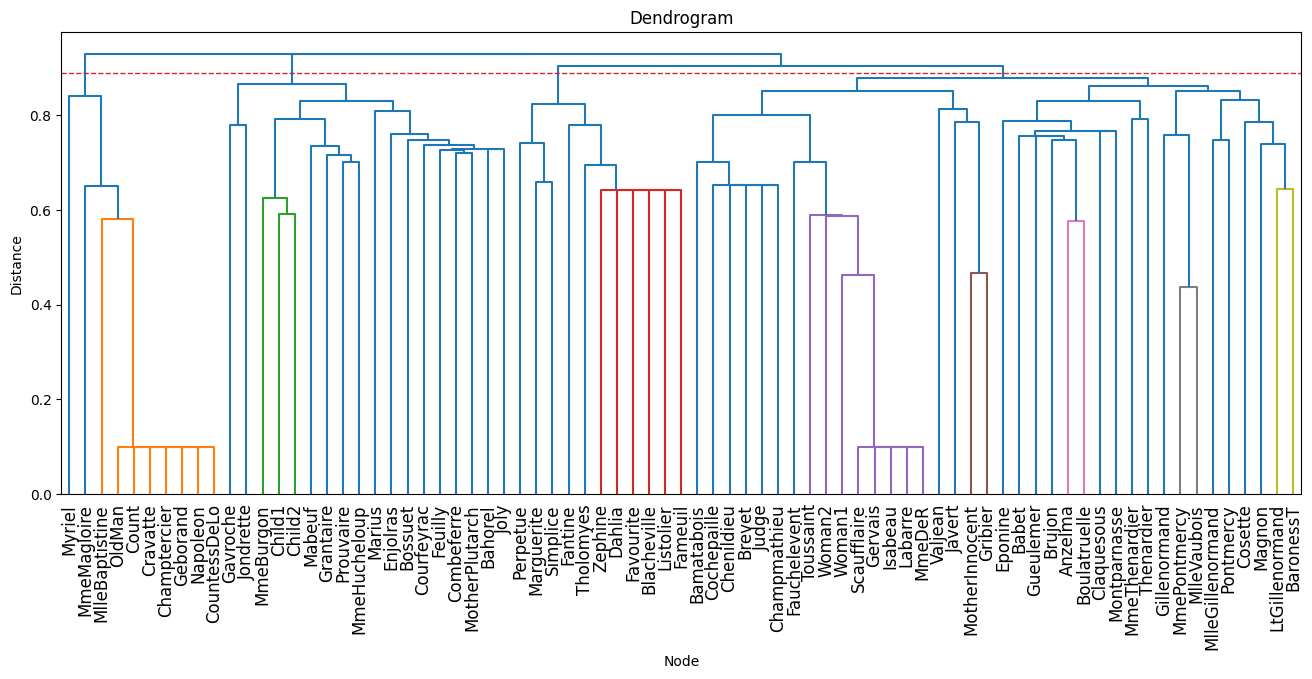

In [44]:
plt.figure(figsize=(16, 6))
linked = linkage(squareform(distance), method='complete')
dendrogram(
    linked, 
    labels=list(G.nodes), 
    leaf_font_size=12
)
plt.axhline(y=0.89, color='tab:red', linestyle='--', linewidth=1)
plt.xlabel('Node')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()

Dựa trên hình trực quan, chúng ta cần chọn một đường ngang mà cho ta sự phân hoạch của đồ thị. Có hai cách tiếp cận: chọn số lượng cụm và chọn khoảng cách tối đa giữa các cụm.

Ví dụ: nếu chúng ta chọn một đường ngang có khoảng cách tối đa 0,89 (đường màu đỏ trên biểu đồ) thì số cụm sẽ là 4.

Bây giờ, bạn hoàn thành hàm `agglomerativeClustering` mà nhận vào một ma trận khoảng cách, cực đại khoảng cách giữa các cụm và trả về một mảng numpy array chứa các nhãn của các cụm. Bạn lưu ý sử dụng  `sklearn.cluster.AgglomerativeClustering` với complete linkage.

In [45]:
def agglomerativeClustering(distance: np.ndarray, max_distance: float) -> np.ndarray:
    # YOUR CODE HERE
    # Chuyển đổi ma trận khoảng cách thành một dạng vector để sử dụng trong AgglomerativeClustering
    distance_vector = squareform(distance)
    
    # Khởi tạo và thực hiện gom cụm kết tụ với linkage complete
    clustering = AgglomerativeClustering(
        n_clusters=None,  # Không xác định trước số lượng cụm
        affinity='precomputed',
        linkage='complete',
        distance_threshold=max_distance  # Sử dụng ngưỡng khoảng cách tối đa
    )
    clustering.fit(distance)
    
    return clustering.labels_


In [46]:
# Test
assert len(set(agglomerativeClustering(distance, 0.8))) == 17
assert len(set(agglomerativeClustering(distance, 0.89))) == 4

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Xem xét đồ thị với khoảng cách cực đại 0.87.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


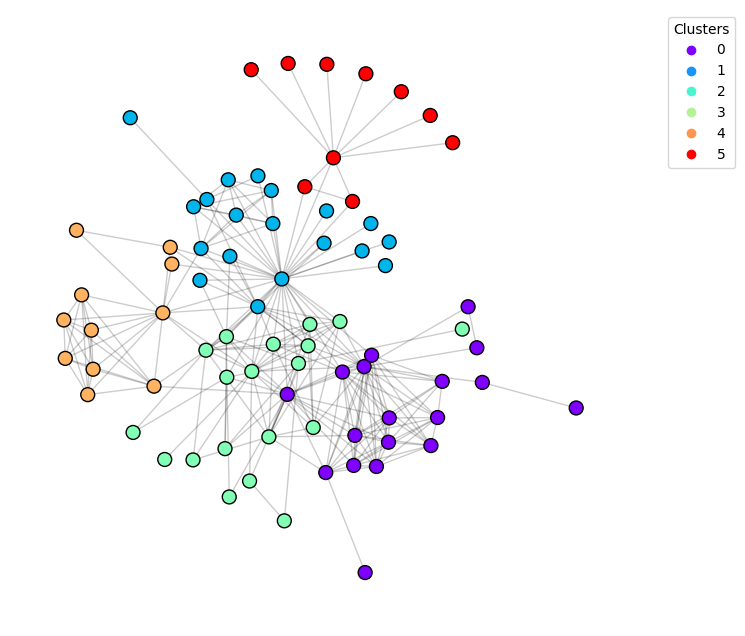

In [47]:
labels = agglomerativeClustering(distance, 0.87)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.legend(*nodes.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Bạn có nhận xét gì không?

## Task 9. Phương pháp Louvain

[Phương pháp Louvain](https://en.wikipedia.org/wiki/Louvain_method) là một trong những công trình nổi tiếng trong nghiên cứu phát hiện cộng đồng. Nó là một phương pháp đơn giản để rút trích cấu trúc cộng đồng của các mạng lưới lớn. Phương pháp này là một phương pháp thuộc nhóm sử dụng heuristic dựa trên tối ưu mô-đun hóa (modularity optimization). 

Trong phần này chúng ta sẽ xem xét phương pháp này trên một đồ thị phân dạng mà có thể biểu diễn một số cấu trúc sinh học.

In [48]:
def fractalGraph(n: int, k: int, G: nx.Graph) -> nx.Graph:
    if k == 0:
        return G
    for node in list(G.nodes):
        newG = nx.complete_graph(n)
        newG = nx.relabel_nodes(
            newG, {node: max(G.nodes)+node+1 for node in newG.nodes})
        G = nx.union(G, newG)
        for edge in G.edges(node):
            G.add_edge(list(G.nodes)[-1], edge[1])
        G.remove_node(node)
    return fractalGraph(n, k-1, G)

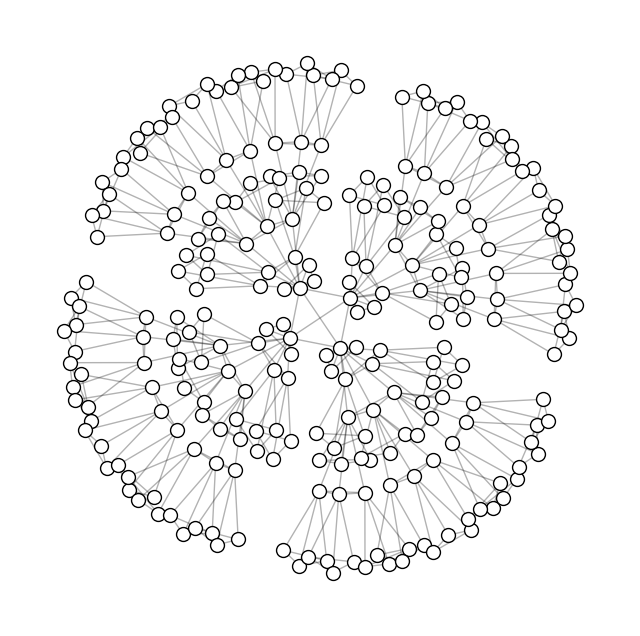

In [49]:
n = 4
fractalG = fractalGraph(n, 3, nx.complete_graph(n))

plt.figure(figsize=(8, 8))
frac_pos = nx.kamada_kawai_layout(fractalG)
nx.draw_networkx_nodes(fractalG, frac_pos, node_color='white',
                       edgecolors='black', node_size=100)
nx.draw_networkx_edges(fractalG, frac_pos, alpha=0.3)
plt.axis('off')
plt.show()

Phương pháp Louvain là một thuật toán tham lam dựa trên độ lợi modularity. Ta có thể mô tả nó thành từng pha như sau:
- Pha 1:
    - Bước 1: Đặt mỗi đỉnh trong cộng đồng của chính nó.
    - Bước 2: Với mỗi đỉnh, tính toán độ lợi modularity bằng cách loại bỏ nó từ cộng đồng của nó và thay thế nó trong cộng đồng của láng giềng.
    - Bước 3: Đặt đỉnh vào trong cộng đồng với độ lợi modularity cao nhất.
    - Bước 4: Lặp lại bước 2, 3 cho đến khi độ lợi modularity không tăng được nữa.

- Pha 2: 
    - Bước 1: Gộp các cộng đồng thành "siêu đỉnh"
    - Bước 2: Chuyển các cạnh bên trong cộng đồng thành khuyên, cạnh giữa các cộng đồng thành các cạnh song song.

Lặp lại Pha 1, 2 cho đến khi độ lợi modularity không tăng được nữa.

In [50]:
def louvainMethod(G: nx.Graph) -> Tuple[np.ndarray, np.ndarray, nx.Graph]:

    # Pha 1
    communities = unfoldedCommunities(G)
    labels = []
    for node in G.nodes:
        for i, c in enumerate(communities):
            if node in c:
                labels.append(i)

    # Pha 2
    nextG = nx.empty_graph(len(communities), nx.MultiGraph)
    for e in G.edges:
        for i in range(len(communities)):
            for j in range(len(communities)):
                if e[0] in communities[i] and e[1] in communities[j]:
                    nextG.add_edge(i, j)

    # Shuffle colors for better visualization
    palette = np.unique(labels)
    key = np.random.permutation(palette)
    labels = key[np.digitize(labels, palette, right=True)]

    return communities, labels, nextG

Bây giờ, bạn hoàn thành hàm `unfoldedCommunities` mà nhận đầu vào là một đồ thị, thực hiện Pha 1 và trả về mảng numpy array của các cộng đồng của đỉnh. 

Ví dụ: nếu ta có hai cộng đồng, cộng đồng 1 - [1,2] và cộng đồng 2 - [3,4,5] thì đầu ra có dạng là [[1,2],[3,4,5]].

In [51]:
def unfoldedCommunities(G: nx.Graph) -> np.ndarray:
    # YOUR CODE HERE
    # Khởi tạo các cộng đồng, mỗi đỉnh là một cộng đồng
    nodes = list(G.nodes())
    node_to_index = {node: i for i, node in enumerate(nodes)}
    index_to_node = {i: node for i, node in enumerate(nodes)}
    communities = {node: {node} for node in G.nodes()}
    adj_matrix = nx.to_numpy_array(G)
    degrees = dict(G.degree(weight='weight'))
    m = G.size(weight='weight')
    
    while True:
        improvement = False
        for node in nodes:
            node_index = node_to_index[node]
            current_community = communities[node]
            best_community = current_community
            best_gain = 0
            
            # Tính modularity hiện tại
            total_weight_in_community = sum(adj_matrix[node_index][node_to_index[neighbor]] for neighbor in current_community)
            degree_node = degrees[node]
            total_weight_community = sum(degrees[n] for n in current_community)
            best_gain = total_weight_in_community - (degree_node * total_weight_community) / (2 * m)
            
            for neighbor in G.neighbors(node):
                neighbor_community = communities[neighbor]
                if neighbor_community != current_community:
                    total_weight_in_neighbor_community = sum(adj_matrix[node_index][node_to_index[neighbor]] for neighbor in neighbor_community)
                    total_weight_neighbor_community = sum(degrees[n] for n in neighbor_community)
                    gain = total_weight_in_neighbor_community - (degree_node * total_weight_neighbor_community) / (2 * m)
                    if gain > best_gain:
                        best_gain = gain
                        best_community = neighbor_community
            
            # Nếu có độ lợi modularity cao hơn thì di chuyển đỉnh đến cộng đồng mới
            if best_community != current_community:
                improvement = True
                communities[node].remove(node)
                if len(communities[node]) == 0:
                    del communities[node]
                communities[node] = best_community
                best_community.add(node)
        
        if not improvement:
            break
    
    # Chuyển đổi từ dictionary các cộng đồng sang danh sách các danh sách các đỉnh
    result = []
    seen_communities = set()
    for community in communities.values():
        if id(community) not in seen_communities:
            result.append(list(community))
            seen_communities.add(id(community))
    return result

In [52]:
# Test
n = 4
fractalG = fractalGraph(n, 2, nx.complete_graph(n))
iterG = fractalG.copy()
communities, labels, nextG = louvainMethod(iterG)

assert len(set(labels)) == 16
assert len(set(labels[52:56])) == 1
assert len(set(labels[52:57])) == 2
assert nextG.number_of_nodes() == 16
assert round(np.linalg.det(nx.to_numpy_array(nextG)) * 1e-10, 4) == 136.5257

Chúng ta hãy xem các lần lặp lại đang diễn ra như thế nào. Đối với mỗi lần lặp, chúng tôi vẽ một đồ thị trong đó màu nút tương ứng với cộng đồng chưa được mở.

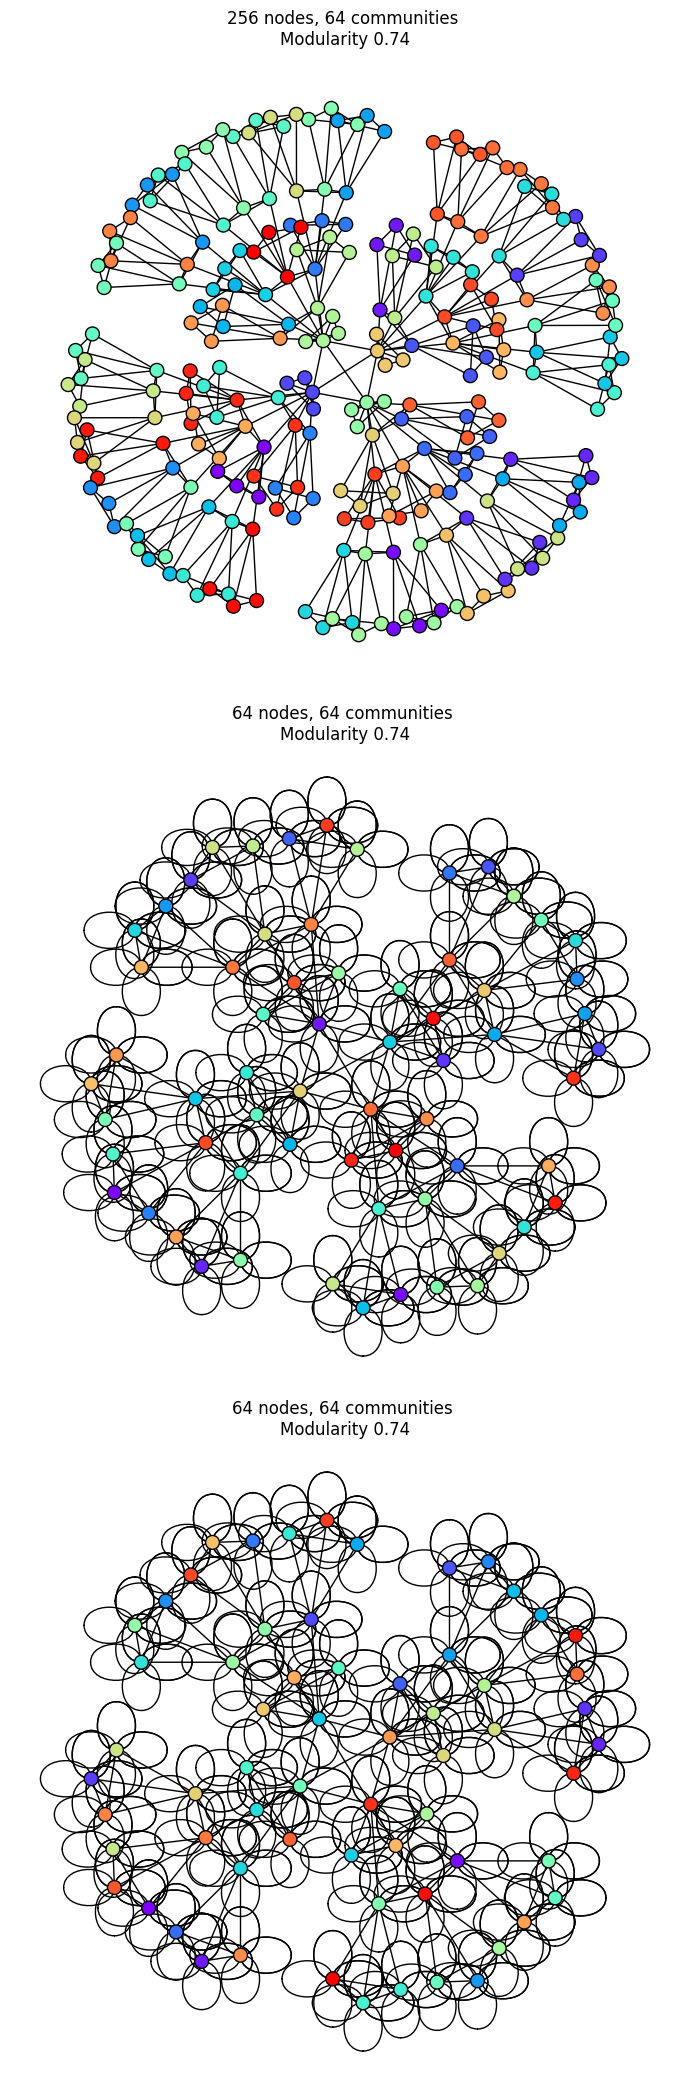

In [53]:
n = 4
fractalG = fractalGraph(n, 3, nx.complete_graph(n))
iterG = fractalG

plt.figure(figsize=(7, 21))
for i in range(3):
    plt.subplot(3, 1, i+1)
    communities, labels, nextG = louvainMethod(iterG)
    iter_pos = nx.kamada_kawai_layout(iterG)
    nodes = nx.draw_networkx_nodes(
        iterG,
        iter_pos,
        cmap=plt.cm.rainbow,
        node_color=labels,
        edgecolors='black',
        node_size=100)
    nx.draw_networkx_edges(
        iterG,
        iter_pos,
        node_size=100)
    plt.axis('off')
    plt.title(
        '{} nodes, {} communities \nModularity {:.2f}'.format(
            len(iterG), len(communities), nx.community.modularity(iterG, communities)))
    iterG = nextG
    
plt.tight_layout()
plt.show()

Bạn có nhận xét gì?

## Task 10. Phân hoạch "bản ngã" (Ego-Splitting)

Phân hoạch "bản ngã" hay Ego-Splitting là một framework cho việc phát hiện các cộng đồng trong mạng lưới phức. Nó tận dụng các cấu trúc cục bộ được biết là "ego-nets", tức là đồ thị con suy dẫn bởi láng giềng của nó, để phát hiện các cụm chồng chéo lên nhau. Ego-Splitting là một framework có tính mở rộng và linh hoạt cao, với những đảm bảo về mặt lý thuyết có thể chứng minh được, giúp giảm vấn đề phân cụm chồng chéo phức tạp thành vấn đề không chồng chéo (phân vùng) đơn giản hơn và dễ giải quyết hơn.

Xem xét một đồ thị như sau:

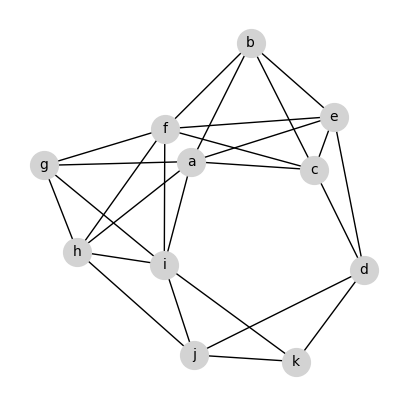

In [54]:
adjlist = [
    'a b c e h g i',
    'f b c e h g i',
    'b e c',
    'g i h',
    'e c d',
    'c d',
    'i h j k',
    'h j',
    'j d k',
    'd k'
]

G = nx.parse_adjlist(adjlist, delimiter=' ')
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(5, 5))
nx.draw_networkx(
    G,
    pos=pos,
    node_size=400,
    node_color='lightgray',
    edge_color='black',
    with_labels=True,
    font_size=10
)
plt.axis('off')
plt.show()

Thuật toán ego-splitting xử lý một đồ thị $G = (V, E)$ và cho ra kết quả là một tập hợp các cluster $S$ như sau:
- Bước 1: Với mỗi đỉnh $u$, ta xử dụng thuật toán gom cụm cục bộ để phân hoạch ego-net của $u$.
- Bước 2: Tạo ra một tập personas $V'$. Mỗi đỉnh $u$ trong $V$ sẽ tương ứng với personas $t_u$ trong $V'$.
- Bước 3: Thêm cạnh giữa các personas.
- Bước 4: Áp dụng thuật toán gom cụm toàn cục.

In [55]:
def egoSplitting(graph: nx.Graph) -> nx.Graph:
    ego_nets = generateEgoNets(graph)
    persona_graph = generatePersonaGraph(ego_nets)
    return personaClustering(personaG)

Để hoàn thành, bạn cần hoàn thành một hàm `generateEgoNets` mà nhận đầu vào là một đồ thị và trả về một từ điển trong đó các khóa là các đỉnh và giá trị của chúng là ego-nets:

```
{'a': ego-net of the node a, 'b': ego-net of the node b, ...}
```

_Gợi ý: Bạn cần sử dụng `nx.ego_graph`_


In [56]:
def generateEgoNets(graph: nx.Graph) -> Dict:
    # YOUR CODE HERE
    ego_nets = {}
    for node in graph.nodes():
        ego_net = nx.ego_graph(graph, node)
        ego_net.remove_node(node)
        ego_nets[node] = ego_net
    return ego_nets

In [57]:
# Test
ego_nets = generateEgoNets(G)
assert set(ego_nets.keys()) == {'a', 'b', 'c',
                                'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'}
assert set(ego_nets['d'].nodes) == {'c', 'e', 'j', 'k'}
assert set(ego_nets['f'].nodes) == {'b', 'c', 'e', 'g', 'h', 'i'}

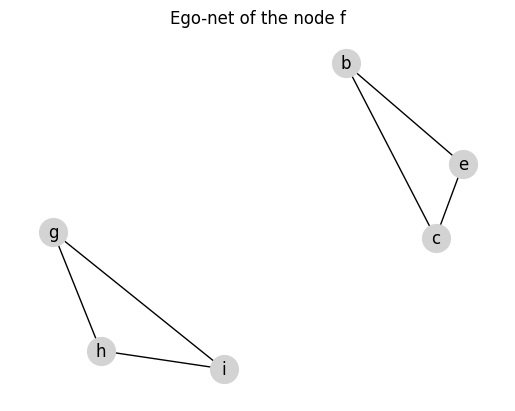

In [58]:
nx.draw_networkx(ego_nets['f'], pos=nx.kamada_kawai_layout(G),
                 node_color='lightgray', node_size=400)
plt.title('Ego-net of the node f')
plt.axis('off')
plt.show()

Tiếp theo, ta cần phân hoạch mỗi ego-net bằng cách sử dụng bất cứ cái phương pháp gom cụm nào. Để cho đơn giản hãy sử dụng phương pháp phát hiện các thành phần liên thông.

In [59]:
def egoClustering(graph: nx.Graph) -> List:
    return [cc for cc in nx.connected_components(graph)]

Tiếp, bạn hoàn thành hàm `generatePersonaGraph` mà nhận đầu vào là một từ điển ego-net và trả về một đồ thị persona:
- Bước 1: Áp dụng gom cụm ego cho mỗi ego-net
- Bước 2: Thêm một bản sao của ego-node vào mỗi cluster và liên kết nó với từng thành viên. Nếu có hơn một cluster thì bản sao được đặt tên là node name + cluster index. Lấy ví dụ, nếu ego-net `a` cho các cụm `[b, c]` và `[d]` thì ta thêm cạnh `[a0, b]`, `[a0, c]`, và `[a1, d]`. Ngược lại, tên bản sao sẽ được đặt là tên của đỉnh.
- Bước 3: Hội tất cả các ego-nets vào đồ thị persona. Loại bỏ tất cả đỉnh mà có bản sao. Lấy vị, nếu đồ thị có các đỉnh `a`, `a0`, `a1`, thì ta sẽ loại bỏ `a`.

In [60]:
def generatePersonaGraph(ego_nets: Dict) -> nx.Graph:
    # YOUR CODE HERE
    personaG = nx.Graph()

    original_nodes_with_copies = set()

    for node, ego_net in ego_nets.items():
        clusters = egoClustering(ego_net)
        if len(clusters) > 1:
            for idx, cluster in enumerate(clusters):
                persona_node = f"{node}{idx}"
                personaG.add_node(persona_node)
                for member in cluster:
                    personaG.add_edge(persona_node, member)
            original_nodes_with_copies.add(node)
        else:
            for cluster in clusters:
                persona_node = node
                personaG.add_node(persona_node)
                for member in cluster:
                    personaG.add_edge(persona_node, member)

    # Loại bỏ tất cả các đỉnh gốc mà có bản sao
    personaG.remove_nodes_from(original_nodes_with_copies)

    return personaG


In [61]:
# Test
ego_nets = generateEgoNets(G)
personaG = generatePersonaGraph(ego_nets)
assert set(personaG.nodes) == {'a0', 'a1', 'b', 'c',
                               'd0', 'd1', 'e', 'f0', 'f1', 'g', 'h', 'i', 'j', 'k'}
assert {i[0] for i in personaG.neighbors('k')} == {'d', 'i', 'j'}
assert {i[0] for i in personaG.neighbors('g')} == {'a', 'f', 'h', 'i'}

Cuối cùng, ta cần áp dụng bất kỳ thuật toán gom cụm nào cho đồ thị persona. Khuyến khích xài những thuật toán đơn giản :). Và ta cũng cần loại bỏ các chỉ số cụm từ tên đỉnh nữa. 

In [62]:
def personaClustering(graph: nx.Graph) -> List:
    communities = [cc for cc in nx.connected_components(graph)]
    for c in communities:
        for node in c:
            c.remove(node)
            c.add(node[0])
    return communities

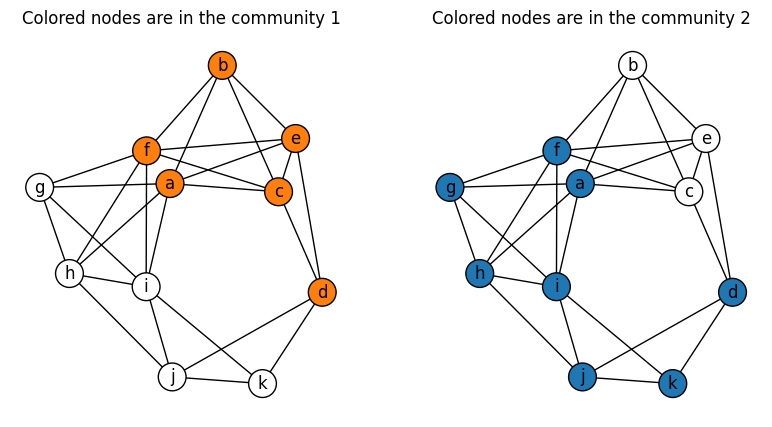

In [63]:
plt.figure(figsize=(15, 5))
pos = nx.kamada_kawai_layout(G)
c_colors = ['tab:orange', 'tab:blue', 'tab:green']
for i, c in enumerate(egoSplitting(G)):
    plt.subplot(1, 3, i+1)
    color = []
    for node in G.nodes:
        color.append(c_colors[i] if node in c else 'white')
    nx.draw_networkx(G, pos=pos, node_color=color,
                     edgecolors='black', node_size=400)
    plt.axis('off')
    plt.title('Colored nodes are in the community {}'.format(i+1))

## Task 11. Lan truyền nhãn (Label propogation) 

Phương pháp lan truyền nhãn dựa trên ý tương đơn giản như sau: mỗi đỉnh được khởi tạo với một nhãn duy nhất và tại mỗi bước thì mỗi nút sẽ nhận được nhãn mà hầu hết các láng giềng của nó đang có.

Để hoàn thành phần này, bạn cần code hàm `updateLabels` mà nhận đầu vào là một đồ thị, mảng numpy array theo thứ tự `graph.nodes` và trả về các nhãn mới. Nhãn của đỉnh là một nhãn ngẫu nhiên xuất hiện với tần số cao giữa các láng giềng của nó ở bước trước đó. Thứ tự trong `n` đỉnh của mạng được cập nhật tại mỗi bước lặp thì được chọn ngẫu nhiên.

In [64]:
def updateLabels(graph: nx.Graph, labels: np.ndarray) -> np.ndarray:
    # YOUR CODE HERE
    new_labels = labels.copy()
    nodes = list(graph.nodes())
    random.shuffle(nodes)  # Chọn ngẫu nhiên thứ tự cập nhật các đỉnh
    
    for node in nodes:
        neighbor_labels = [labels[neighbor] for neighbor in graph.neighbors(node)]
        if neighbor_labels:
            new_label = max(set(neighbor_labels), key=neighbor_labels.count)
            new_labels[node] = new_label

    return new_labels

In [65]:
# Test
G = nx.karate_club_graph()
labels = np.array(list(G.nodes)) # initial partition
new_labels = updateLabels(G, labels)
assert new_labels.shape == (34, )
assert len(set(new_labels)) < len(set(labels))
G = nx.star_graph(4)
labels = np.array(list(G.nodes)) # initial partition
for _ in range(5):
    labels = updateLabels(G, labels)
new_labels = updateLabels(G, labels)
assert len(set(new_labels - labels)) == 2
assert np.sum(list(set(new_labels - labels))) == 0

In [66]:
def plotPropogation(G: nx.Graph, update_method, n: int = 50):
    pos = nx.kamada_kawai_layout(G)
    labels = np.array(list(G.nodes))
    for i in range(n):
        clear_output(wait=True)
        labels = update_method(G, labels)
        plt.figure(figsize=(6, 6))
        nx.draw_networkx_nodes(
            G, pos=pos, node_color=labels, cmap=plt.cm.tab10_r)
        nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
        nx.draw_networkx_labels(G, pos=pos)
        plt.axis('off')
        plt.title('Iteration {}/{}'.format(i+1, n))
        plt.show()

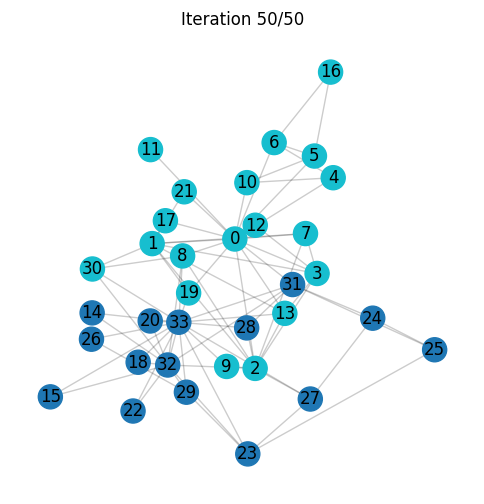

In [67]:
plotPropogation(nx.karate_club_graph(), updateLabels)

Có một vấn đề ở đây là các đồ thị con trong mạng mà là lưỡng phân hoặc xém lưỡng phân trong cấu trúc lẫn đến hiện tượng dao động nhãn (oscillations labels). Điều này đúng trong một số trường hợp mà các cộng đồng được lấy từ một đồ thị hình sao.

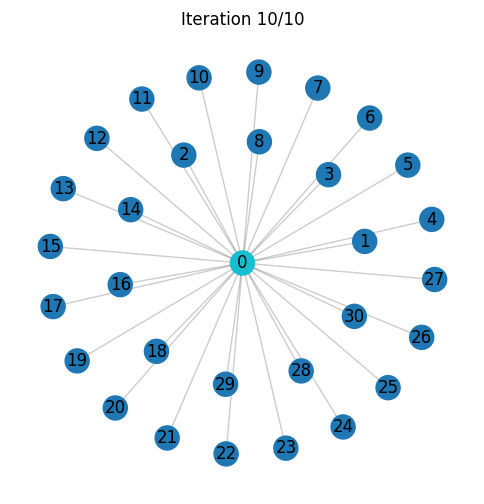

In [68]:
plotPropogation(nx.star_graph(30), updateLabels, 10)

Vậy thì phải làm sao đây?

Do đó, ta cần một cơ chế cập nhật bất đồng bộ (asynchronous updating) mà trong đó một số láng giềng đã có được cập nhật lại bước lặp hiện tại trong khi một số khác thì không.

Để làm được điều này, bạn cần viết một hàm `asyncUpdateLabels` mà tạo ra việc cập nhất bất đồng bộ. Thứ tự trong tất cả `n` đỉnh của mạng được cập nhật tại mỗi lần lặp được chọn một cách ngẫu nhiên.

In [69]:
def asyncUpdateLabels(graph: nx.Graph, labels: np.ndarray) -> np.ndarray:
    # YOUR CODE HERE
    new_labels = labels.copy()
    nodes = list(graph.nodes())
    random.shuffle(nodes)  # Chọn ngẫu nhiên thứ tự cập nhật các đỉnh
    
    for node in nodes:
        neighbor_labels = [new_labels[neighbor] for neighbor in graph.neighbors(node)]
        if neighbor_labels:
            new_label = max(set(neighbor_labels), key=neighbor_labels.count)
            new_labels[node] = new_label

    return new_labels

In [70]:
G = nx.karate_club_graph()
labels = np.array(list(G.nodes))  # initial partition
new_labels = asyncUpdateLabels(G, labels)
assert new_labels.shape == (34, )
assert len(set(new_labels)) < len(set(labels))
G = nx.star_graph(4)
labels = np.array(list(G.nodes))  # initial partition
for _ in range(5):
    labels = asyncUpdateLabels(G, labels)
new_labels = asyncUpdateLabels(G, labels)
assert np.all(new_labels - labels == 0)

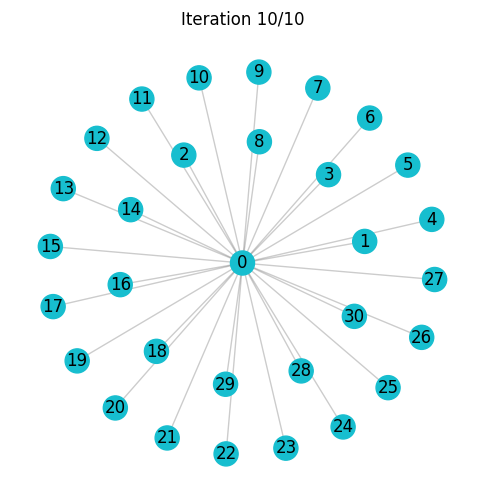

In [71]:
plotPropogation(nx.star_graph(30), asyncUpdateLabels, 10)

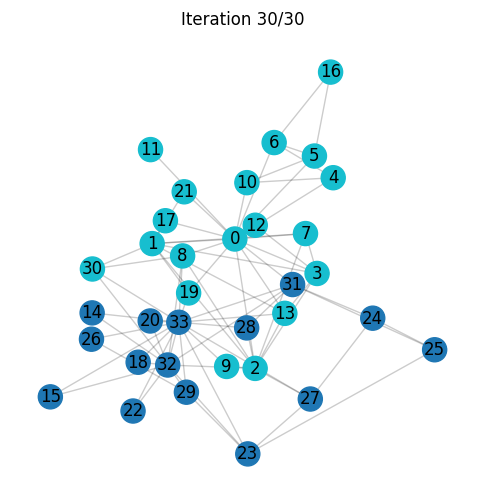

In [72]:
plotPropogation(nx.karate_club_graph(), asyncUpdateLabels, 30)

Mệt quá, thôi nghỉ ngơi nào. Sắp hết môn học rồi!